# CodeStates AI Section2 Project

AI_15_정경재

- Project : Hypertension Predictive Model
- 프로젝트 : 한국형 고혈압 예측 모델 개발
    - 고혈압 진단기준에 따른 차이가 있을까?

# Modeling

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

## 1. Data preparation

In [2]:
df0 = pd.read_csv('data/KNHANES_8th_final2.csv')
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11422 entries, 0 to 11421
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             11422 non-null  object 
 1   year           11422 non-null  int64  
 2   sex            11422 non-null  int64  
 3   age            11422 non-null  int64  
 4   heavy_drink    11422 non-null  int64  
 5   smoke          11422 non-null  int64  
 6   genetic_hbp    11422 non-null  float64
 7   BMI            11422 non-null  float64
 8   diabetes       11422 non-null  int64  
 9   hyper_chol     11422 non-null  int64  
 10  triglycerides  11422 non-null  float64
 11  HBP_US         11422 non-null  int64  
 12  HBP_EU         11422 non-null  int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 1.1+ MB


In [3]:
df0.ID.duplicated().sum()

0

In [4]:
df1 = df0.iloc[:,2:]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11422 entries, 0 to 11421
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex            11422 non-null  int64  
 1   age            11422 non-null  int64  
 2   heavy_drink    11422 non-null  int64  
 3   smoke          11422 non-null  int64  
 4   genetic_hbp    11422 non-null  float64
 5   BMI            11422 non-null  float64
 6   diabetes       11422 non-null  int64  
 7   hyper_chol     11422 non-null  int64  
 8   triglycerides  11422 non-null  float64
 9   HBP_US         11422 non-null  int64  
 10  HBP_EU         11422 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 981.7 KB


In [5]:
profile = ProfileReport(df1,minimal=True)
profile

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
train, test = train_test_split(df1,test_size=0.2,random_state=42)

print('분리전 : {}\n'.format(df1.shape))
print('훈련&검증데이터 : {}'.format(train.shape))
print('테스트데이터 : {}'.format(test.shape))

분리전 : (11422, 11)

훈련&검증데이터 : (9137, 11)
테스트데이터 : (2285, 11)


In [7]:
features = df1.drop(columns=['HBP_US','HBP_EU']).columns
target_us = 'HBP_US'
target_eu = 'HBP_EU'

X_train = train[features]
y_train_us = train[target_us]
y_train_eu = train[target_eu]

X_test = test[features]
y_test_us = test[target_us]
y_test_eu = test[target_eu]

print('X y 분리 후 shape\n')
print('X_train : {}'.format(X_train.shape))
print('y_train(US) : {}'.format(y_train_us.shape))
print('y_train(EU) : {}\n'.format(y_train_eu.shape))
print('X_test : {}'.format(X_test.shape))
print('y_test(US) : {}'.format(y_test_us.shape))
print('y_test(EU) : {}'.format(y_test_eu.shape))

X y 분리 후 shape

X_train : (9137, 9)
y_train(US) : (9137,)
y_train(EU) : (9137,)

X_test : (2285, 9)
y_test(US) : (2285,)
y_test(EU) : (2285,)


In [8]:
profile_train = ProfileReport(X_train, minimal=True)
profile_train

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2. Baseline

### US criteria

Target(HBP_US) 비율


1    0.520521
0    0.479479
Name: HBP_US, dtype: float64

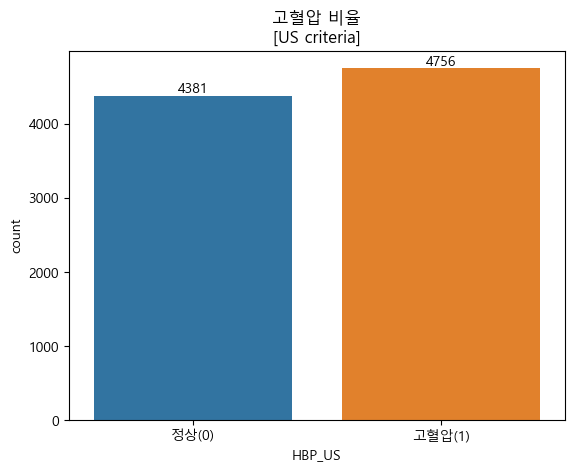

In [9]:
count_us = y_train_us.value_counts().sort_index()
count_label = ['정상(0)','고혈압(1)']
print('Target(HBP_US) 비율')
display(y_train_us.value_counts(normalize=True))
ax = sns.countplot(x = y_train_us)
ax.bar_label(ax.containers[0])
plt.xticks([0,1],count_label)
plt.title('고혈압 비율\n[US criteria]')
plt.show()

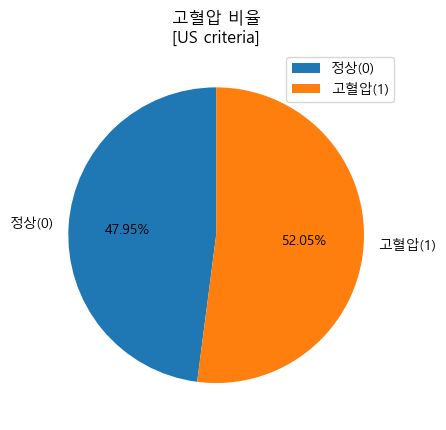

In [10]:
plt.pie(x = count_us,labels=count_label,autopct='%.2f%%',startangle=90)
plt.legend(loc = 'upper right')
plt.title('고혈압 비율\n[US criteria]')
plt.show()

In [11]:
base_us = y_train_us.mode()[0]
baseline_us = [base_us]*len(y_train_us)
print("Baseline accuracy(US): {}".format(
    accuracy_score(y_train_us, baseline_us)))
print("Baseline AUC_score(US): {}".format(
    roc_auc_score(y_train_us, baseline_us)))

Baseline accuracy(US): 0.5205209587391922
Baseline AUC_score(US): 0.5


### EU criteria

Target(HBP_EU) 비율


0    0.673635
1    0.326365
Name: HBP_EU, dtype: float64

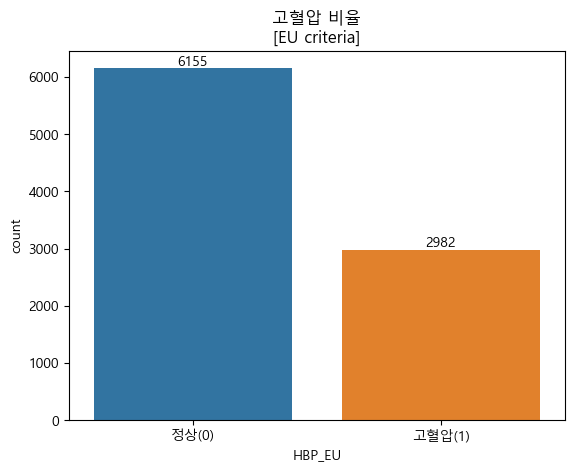

In [12]:
count_eu = y_train_eu.value_counts().sort_index()
print('Target(HBP_EU) 비율')
display(y_train_eu.value_counts(normalize=True))
ax = sns.countplot(x = y_train_eu)
ax.bar_label(ax.containers[0])
plt.xticks([0,1],count_label)
plt.title('고혈압 비율\n[EU criteria]')
plt.show()

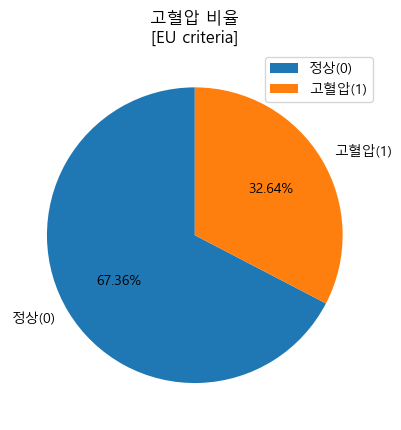

In [13]:
plt.pie(x = count_eu,labels=count_label,autopct='%.2f%%',startangle=90)
plt.legend(loc = 'upper right')
plt.title('고혈압 비율\n[EU criteria]')
plt.show()

In [14]:
base_eu = y_train_eu.mode()[0]
baseline_eu = [base_eu]*len(y_train_eu)
print("Baseline accuracy(EU): {}".format(
    accuracy_score(y_train_eu, baseline_eu)))
print("Baseline AUC_score(EU): {}".format(
    roc_auc_score(y_train_eu, baseline_eu)))

Baseline accuracy(EU): 0.6736346722118858
Baseline AUC_score(EU): 0.5


### US & EU

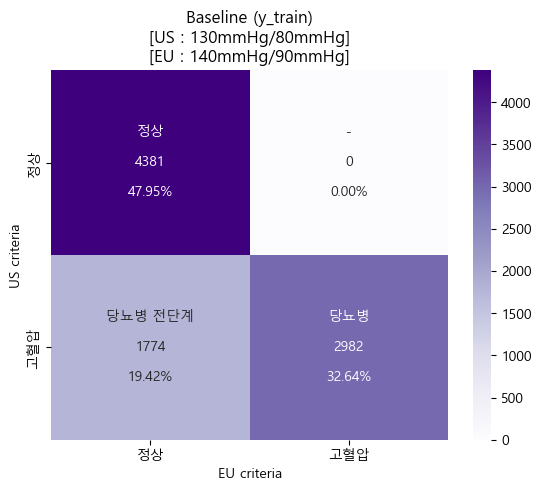

In [15]:
cfm_baseline_us = confusion_matrix(y_train_us,y_train_eu)
group_names_baseline_us = ['정상','-','당뇨병 전단계','당뇨병']
group_counts_baseline_us = ['{0:0.0f}'.format(value) for value in cfm_baseline_us.flatten()]
group_percentages_baseline_us = ['{0:.2%}'.format(value) for value in cfm_baseline_us.flatten()/np.sum(cfm_baseline_us)]
labels_baseline_us = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_baseline_us,group_counts_baseline_us,group_percentages_baseline_us)]
labels_baseline_us = np.asarray(labels_baseline_us).reshape(2,2)
tick_baseline_us = ['정상','고혈압']
sns.heatmap(cfm_baseline_us, annot=labels_baseline_us, fmt='',cmap='Purples',xticklabels=tick_baseline_us,yticklabels=tick_baseline_us)
plt.xlabel('EU criteria')
plt.ylabel('US criteria')
plt.title('Baseline (y_train)\n[US : 130mmHg/80mmHg]\n[EU : 140mmHg/90mmHg]')
plt.show()

## 3. Modeling (default)

### 3-1. Logistic Regression

In [16]:
log_cols = ['triglycerides']

X_train_log = X_train.copy()
X_train_log[log_cols] = np.log(X_train_log[log_cols])

X_test_log = X_test.copy()
X_test_log[log_cols] = np.log(X_test_log[log_cols])

print('로그변환 후 shape\n')
print('X_train_log : {}'.format(X_train_log.shape))
print('y_train(US) : {}'.format(y_train_us.shape))
print('y_train(EU) : {}\n'.format(y_train_eu.shape))
print('X_test_log : {}'.format(X_test_log.shape))
print('y_test(US) : {}'.format(y_test_us.shape))
print('y_test(EU) : {}'.format(y_test_eu.shape))

로그변환 후 shape

X_train_log : (9137, 9)
y_train(US) : (9137,)
y_train(EU) : (9137,)

X_test_log : (2285, 9)
y_test(US) : (2285,)
y_test(EU) : (2285,)


In [17]:
profile_log = ProfileReport(X_train_log, minimal=True, dark_mode=True)
profile_log

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
X_train_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9137 entries, 2249 to 7270
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex            9137 non-null   int64  
 1   age            9137 non-null   int64  
 2   heavy_drink    9137 non-null   int64  
 3   smoke          9137 non-null   int64  
 4   genetic_hbp    9137 non-null   float64
 5   BMI            9137 non-null   float64
 6   diabetes       9137 non-null   int64  
 7   hyper_chol     9137 non-null   int64  
 8   triglycerides  9137 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 713.8 KB


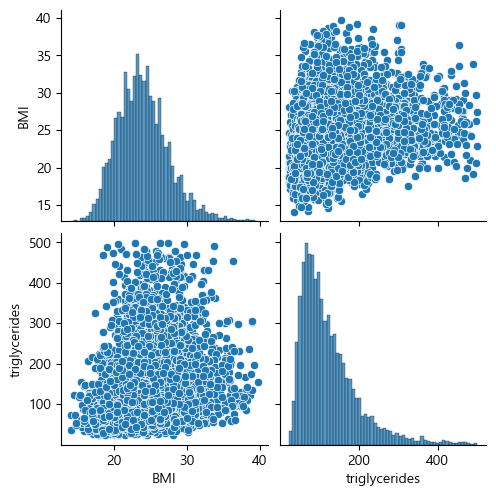

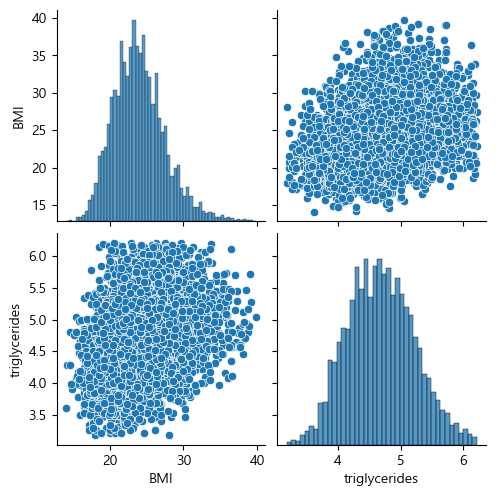

In [19]:
num_feat = ['BMI','triglycerides']
sns.pairplot(X_train[num_feat])
plt.show()
sns.pairplot(X_train_log[num_feat])
plt.show()

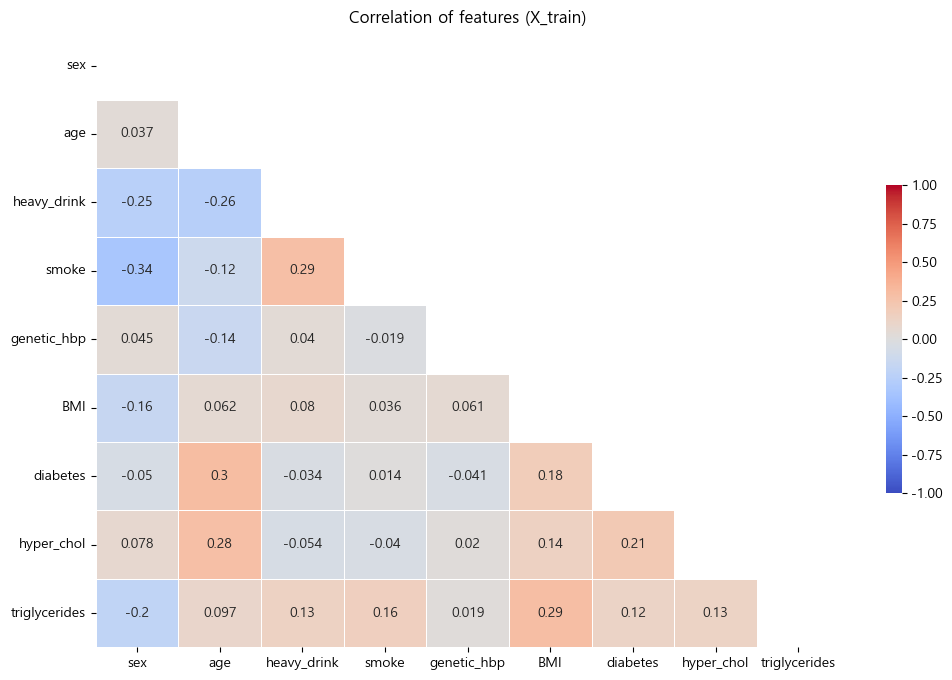

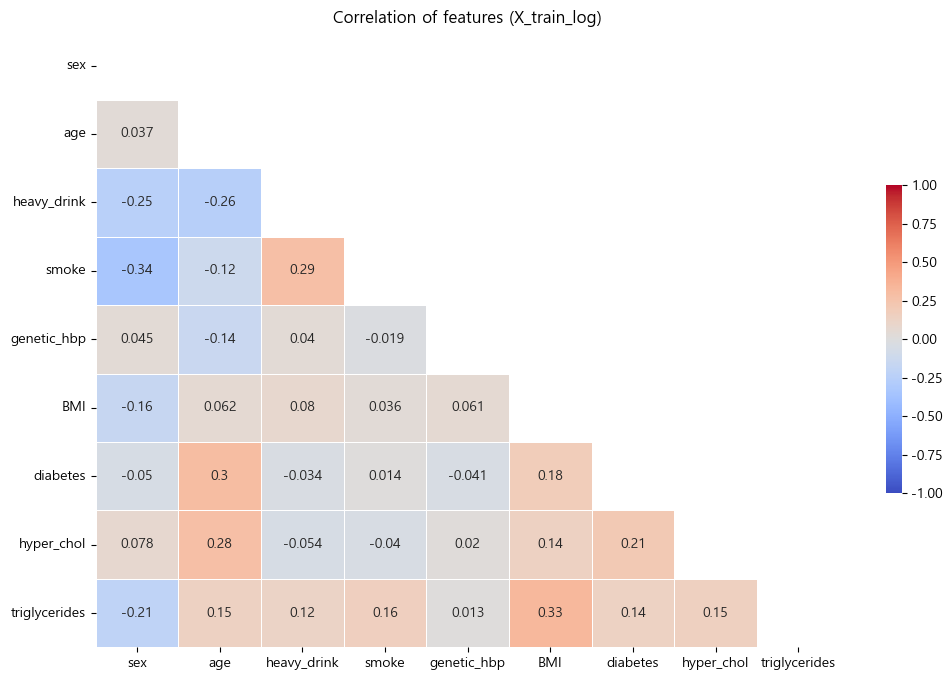

In [20]:
corr_train = X_train.corr()
fig, ax = plt.subplots(figsize=(12,8))
mask = np.zeros_like(corr_train,dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_train,
            cmap='coolwarm',
            annot=True,
            mask=mask,
            linewidths=.5,
            cbar_kws={'shrink':.5},
            vmin=-1,
            vmax=1)
plt.title('Correlation of features (X_train)')
plt.show()
corr_train_log = X_train_log.corr()
fig, ax = plt.subplots(figsize=(12,8))
mask = np.zeros_like(corr_train_log,dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_train_log,
            cmap='coolwarm',
            annot=True,
            mask=mask,
            linewidths=.5,
            cbar_kws={'shrink':.5},
            vmin=-1,
            vmax=1)
plt.title('Correlation of features (X_train_log)')
plt.show()

#### US criteria

In [21]:
pipe_logis_us = make_pipeline(
    MinMaxScaler(),
    LogisticRegression()
)
pipe_logis_us.fit(X_train_log,y_train_us)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])

In [22]:
CV_pred_logis_us = cross_val_predict(pipe_logis_us,X_train_log,y_train_us,cv=5,n_jobs=-1)
df_logis_us = pd.DataFrame(data={'y_real_us':y_train_us,
                                 'y_pred_us':CV_pred_logis_us})
table_logis_us = pd.crosstab(df_logis_us['y_real_us'],df_logis_us['y_pred_us'])
display(table_logis_us)

y_pred_us     0     1
y_real_us            
0          2919  1462
1          1059  3697

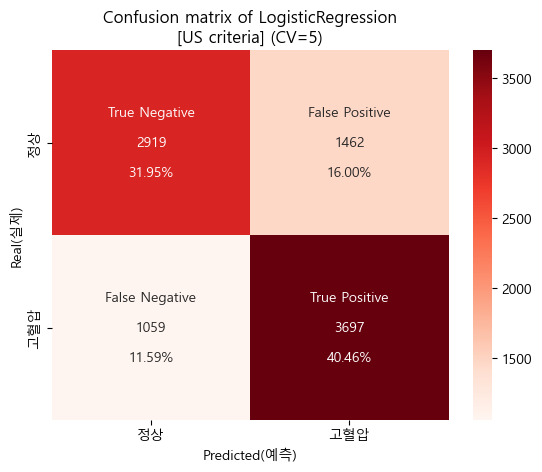

In [23]:
cfm_logis_us = confusion_matrix(y_train_us,CV_pred_logis_us)
group_names_logis_us = ['True Negative','False Positive','False Negative','True Positive']
group_counts_logis_us = ['{0:0.0f}'.format(value) for value in cfm_logis_us.flatten()]
group_percentages_logis_us = ['{0:.2%}'.format(value) for value in cfm_logis_us.flatten()/np.sum(cfm_logis_us)]
labels_logis_us = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_logis_us,group_counts_logis_us,group_percentages_logis_us)]
labels_logis_us = np.asarray(labels_logis_us).reshape(2,2)
tick_logis_us = ['정상','고혈압']
sns.heatmap(cfm_logis_us, annot=labels_logis_us, fmt='',cmap='Reds',xticklabels=tick_logis_us,yticklabels=tick_logis_us)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of LogisticRegression\n[US criteria] (CV=5)')
plt.show()

In [24]:
CV_score_accuracy_logis_us = cross_val_score(pipe_logis_us,X_train_log,y_train_us,cv=5,n_jobs=-1,scoring='accuracy')
print('[US criteria]')
print("Baseline accuracy(US): {}".format(accuracy_score(y_train_us, baseline_us)))
print('LogisticRegression accuracy(US): {}'.format(CV_score_accuracy_logis_us.mean()))

[US criteria]
Baseline accuracy(US): 0.5205209587391922
LogisticRegression accuracy(US): 0.7240900832276369


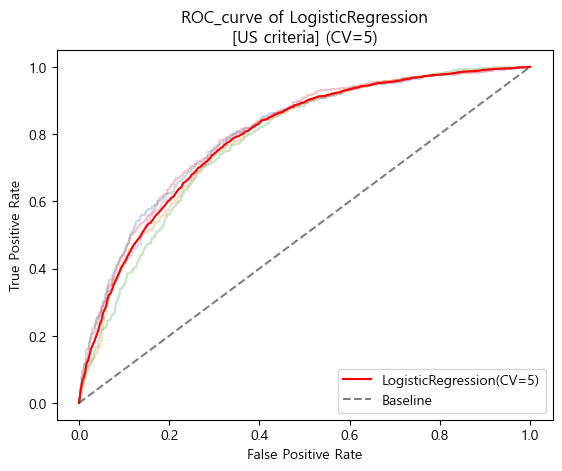

In [25]:
kf_5 = KFold(n_splits=5,shuffle=True,random_state=42)
tprs_logis_us = []
base_fpr_logis_us = np.linspace(0,1,300)

for train_idx, val_idx in kf_5.split(X_train_log):
    X_train_cv, X_val_cv = X_train_log.iloc[train_idx], X_train_log.iloc[val_idx]
    y_train_us_cv, y_val_us_cv = y_train_us.iloc[train_idx], y_train_us.iloc[val_idx]
    
    pipe_logis_us.fit(X_train_cv,y_train_us_cv)
    
    y_val_us_prob = pipe_logis_us.predict_proba(X_val_cv)[:,1]
    FPR_logis_us, TPR_logis_us, _ = roc_curve(y_val_us_cv,y_val_us_prob)
    
    plt.plot(FPR_logis_us,TPR_logis_us,alpha=.25)
    tpr_us = np.interp(base_fpr_logis_us,FPR_logis_us,TPR_logis_us)
    tpr_us[0] = 0.0
    tprs_logis_us.append(tpr_us)
tprs_logis_us = np.array(tprs_logis_us)
mean_tprs_logis_us = tprs_logis_us.mean(axis=0)
plt.plot(base_fpr_logis_us,mean_tprs_logis_us,label='LogisticRegression(CV=5)',color='red')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve of LogisticRegression\n[US criteria] (CV=5)')
plt.legend(loc='lower right')
plt.show()

In [26]:
CV_score_auc_logis_us = cross_val_score(pipe_logis_us,X_train_log,y_train_us,cv=5,n_jobs=-1,scoring='roc_auc')
print('[US criteria]')
print("Baseline AUC_score(US): {}".format(roc_auc_score(y_train_us, baseline_us)))
print('LogisticRegression AUC_score(US) : {}'.format(CV_score_auc_logis_us.mean()))

[US criteria]
Baseline AUC_score(US): 0.5
LogisticRegression AUC_score(US) : 0.7911785348771734


#### EU criteria

In [27]:
pipe_logis_eu = make_pipeline(
    MinMaxScaler(),
    LogisticRegression()
)
pipe_logis_eu.fit(X_train_log,y_train_eu)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])

In [28]:
CV_pred_logis_eu = cross_val_predict(pipe_logis_eu,X_train_log,y_train_eu,cv=5,n_jobs=-1)
df_logis_eu = pd.DataFrame(data={'y_real_eu':y_train_eu,
                                 'y_pred_eu':CV_pred_logis_eu})
table_logis_eu = pd.crosstab(df_logis_eu['y_real_eu'],df_logis_eu['y_pred_eu'])
display(table_logis_eu)

y_pred_eu     0     1
y_real_eu            
0          5288   867
1          1238  1744

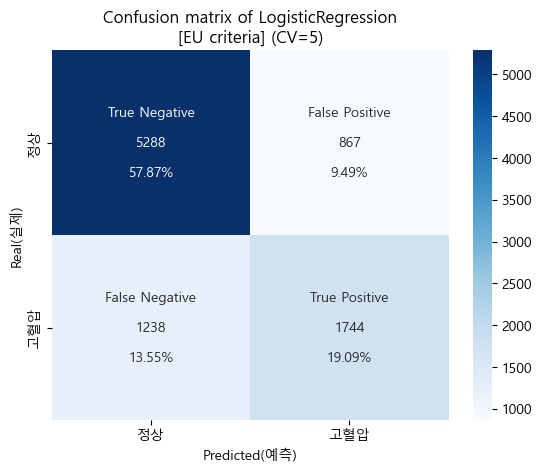

In [29]:
cfm_logis_eu = confusion_matrix(y_train_eu,CV_pred_logis_eu)
group_names_logis_eu = ['True Negative','False Positive','False Negative','True Positive']
group_counts_logis_eu = ['{0:0.0f}'.format(value) for value in cfm_logis_eu.flatten()]
group_percentages_logis_eu = ['{0:.2%}'.format(value) for value in cfm_logis_eu.flatten()/np.sum(cfm_logis_eu)]
labels_logis_eu = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_logis_eu,group_counts_logis_eu,group_percentages_logis_eu)]
labels_logis_eu = np.asarray(labels_logis_eu).reshape(2,2)
tick_logis_eu = ['정상','고혈압']
sns.heatmap(cfm_logis_eu, annot=labels_logis_eu, fmt='',cmap='Blues',xticklabels=tick_logis_eu,yticklabels=tick_logis_eu)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of LogisticRegression\n[EU criteria] (CV=5)')
plt.show()

In [30]:
CV_score_accuracy_logis_eu = cross_val_score(pipe_logis_eu,X_train_log,y_train_eu,cv=5,n_jobs=-1,scoring='accuracy')
print('[EU criteria]')
print("Baseline accuracy(EU): {}".format(accuracy_score(y_train_eu, baseline_eu)))
print('LogisticRegression accuracy(EU): {}'.format(CV_score_accuracy_logis_eu.mean()))

[EU criteria]
Baseline accuracy(EU): 0.6736346722118858
LogisticRegression accuracy(EU): 0.7696176606913798


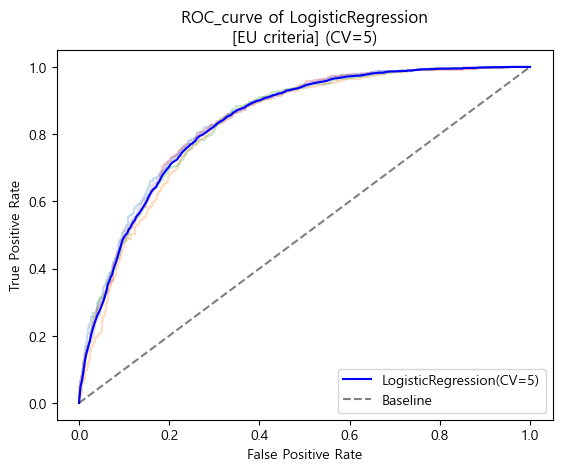

In [31]:
tprs_logis_eu = []
base_fpr_logis_eu = np.linspace(0,1,300)

for train_idx, val_idx in kf_5.split(X_train_log):
    X_train_cv, X_val_cv = X_train_log.iloc[train_idx], X_train_log.iloc[val_idx]
    y_train_eu_cv, y_val_eu_cv = y_train_eu.iloc[train_idx], y_train_eu.iloc[val_idx]
    
    pipe_logis_eu.fit(X_train_cv,y_train_eu_cv)
    
    y_val_eu_prob = pipe_logis_eu.predict_proba(X_val_cv)[:,1]
    FPR_logis_eu, TPR_logis_eu, _ = roc_curve(y_val_eu_cv,y_val_eu_prob)
    
    plt.plot(FPR_logis_eu,TPR_logis_eu,alpha=.25)
    tpr_eu = np.interp(base_fpr_logis_eu,FPR_logis_eu,TPR_logis_eu)
    tpr_eu[0] = 0.0
    tprs_logis_eu.append(tpr_eu)
tprs_logis_eu = np.array(tprs_logis_eu)
mean_tprs_logis_eu = tprs_logis_eu.mean(axis=0)
plt.plot(base_fpr_logis_eu,mean_tprs_logis_eu,label='LogisticRegression(CV=5)',color='blue')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=.5)
plt.title('ROC_curve of LogisticRegression\n[EU criteria] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [32]:
CV_score_auc_logis_eu = cross_val_score(pipe_logis_eu,X_train_log,y_train_eu,cv=5,n_jobs=-1,scoring='roc_auc')
print('[EU criteria]')
print("Baseline AUC_score(EU): {}".format(roc_auc_score(y_train_eu, baseline_eu)))
print('LogisticRegression AUC_score(EU) : {}'.format(CV_score_auc_logis_eu.mean()))

[EU criteria]
Baseline AUC_score(EU): 0.5
LogisticRegression AUC_score(EU) : 0.8377120074901867


#### US & EU

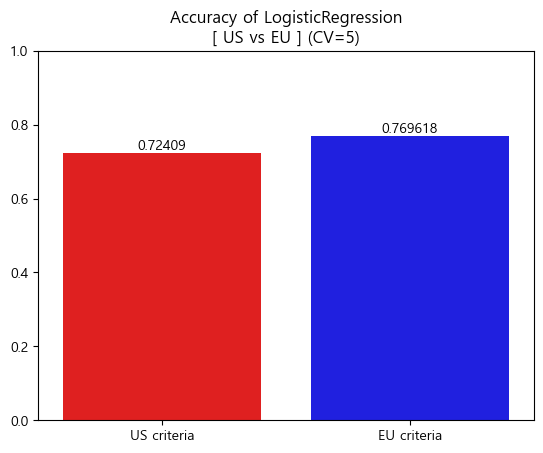

[Accuracy]
LogisticRegression accuracy(US): 0.7240900832276369
LogisticRegression accuracy(EU): 0.7696176606913798


In [33]:
df_accuacy_logis = pd.DataFrame({'US criteria':[CV_score_accuracy_logis_us.mean()]
                                 ,'EU criteria':[CV_score_accuracy_logis_eu.mean()]},
                                index=['Accuracy'])
ax = sns.barplot(data=df_accuacy_logis,palette=['red','blue'])
ax.bar_label(ax.containers[0])
plt.title('Accuracy of LogisticRegression\n[ US vs EU ] (CV=5)')
plt.ylim(0,1)
plt.show()
print('[Accuracy]')
print('LogisticRegression accuracy(US): {}'.format(CV_score_accuracy_logis_us.mean()))
print('LogisticRegression accuracy(EU): {}'.format(CV_score_accuracy_logis_eu.mean()))

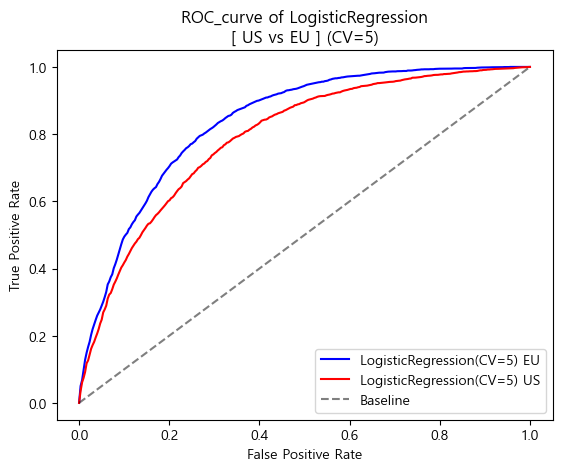

[AUC_score]
LogisticRegression AUC_score(US) : 0.7911785348771734
LogisticRegression AUC_score(EU) : 0.8377120074901867


In [34]:
plt.plot(base_fpr_logis_eu,mean_tprs_logis_eu,label='LogisticRegression(CV=5) EU',color='blue')
plt.plot(base_fpr_logis_us,mean_tprs_logis_us,label='LogisticRegression(CV=5) US',color='red')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=0.5)
plt.title('ROC_curve of LogisticRegression\n[ US vs EU ] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print('[AUC_score]')
print('LogisticRegression AUC_score(US) : {}'.format(CV_score_auc_logis_us.mean()))
print('LogisticRegression AUC_score(EU) : {}'.format(CV_score_auc_logis_eu.mean()))

### 3-2. Decision Tree Classifier

#### US criteria

In [35]:
dtc_us = DecisionTreeClassifier(random_state=42)

dtc_us.fit(X_train,y_train_us)

DecisionTreeClassifier(random_state=42)

In [36]:
CV_pred_dtc_us = cross_val_predict(dtc_us,X_train,y_train_us,cv=5,n_jobs=-1)
df_dtc_us = pd.DataFrame(data={'y_real_us':y_train_us,
                                 'y_pred_us':CV_pred_dtc_us})
table_dtc_us = pd.crosstab(df_dtc_us['y_real_us'],df_dtc_us['y_pred_us'])
display(table_dtc_us)

y_pred_us     0     1
y_real_us            
0          2683  1698
1          1763  2993

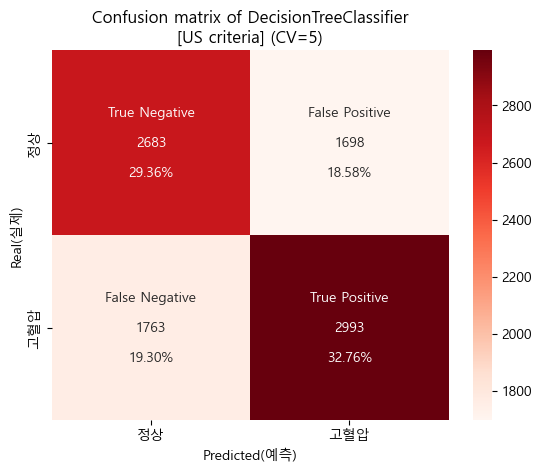

In [37]:
cfm_dtc_us = confusion_matrix(y_train_us,CV_pred_dtc_us)
group_names_dtc_us = ['True Negative','False Positive','False Negative','True Positive']
group_counts_dtc_us = ['{0:0.0f}'.format(value) for value in cfm_dtc_us.flatten()]
group_percentages_dtc_us = ['{0:.2%}'.format(value) for value in cfm_dtc_us.flatten()/np.sum(cfm_dtc_us)]
labels_dtc_us = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_dtc_us,group_counts_dtc_us,group_percentages_dtc_us)]
labels_dtc_us = np.asarray(labels_dtc_us).reshape(2,2)
tick_dtc_us = ['정상','고혈압']
sns.heatmap(cfm_dtc_us, annot=labels_dtc_us, fmt='',cmap='Reds',xticklabels=tick_dtc_us,yticklabels=tick_dtc_us)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of DecisionTreeClassifier\n[US criteria] (CV=5)')
plt.show()

In [38]:
CV_score_accuracy_dtc_us = cross_val_score(dtc_us,X_train,y_train_us,cv=5,n_jobs=-1,scoring='accuracy')
print('[US criteria]')
print("Baseline accuracy(US): {}".format(accuracy_score(y_train_us, baseline_us)))
print('DecisionTreeClassifier accuracy(US): {}'.format(CV_score_accuracy_dtc_us.mean()))

[US criteria]
Baseline accuracy(US): 0.5205209587391922
DecisionTreeClassifier accuracy(US): 0.6212123879708578


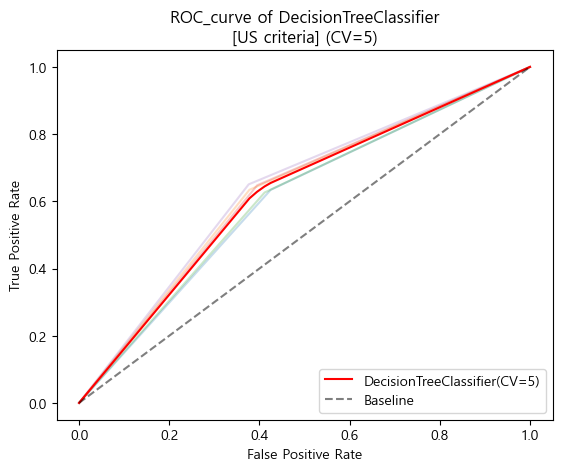

In [39]:
tprs_dtc_us = []
base_fpr_dtc_us = np.linspace(0,1,300)

for train_idx, val_idx in kf_5.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_us_cv, y_val_us_cv = y_train_us.iloc[train_idx], y_train_us.iloc[val_idx]
    
    dtc_us.fit(X_train_cv,y_train_us_cv)
    
    y_val_us_prob = dtc_us.predict_proba(X_val_cv)[:,1]
    FPR_dtc_us, TPR_dtc_us, _ = roc_curve(y_val_us_cv,y_val_us_prob)
    
    plt.plot(FPR_dtc_us,TPR_dtc_us,alpha=.25)
    tpr_us = np.interp(base_fpr_dtc_us,FPR_dtc_us,TPR_dtc_us)
    tpr_us[0] = 0.0
    tprs_dtc_us.append(tpr_us)
tprs_dtc_us = np.array(tprs_dtc_us)
mean_tprs_dtc_us = tprs_dtc_us.mean(axis=0)
plt.plot(base_fpr_dtc_us,mean_tprs_dtc_us,label='DecisionTreeClassifier(CV=5)',color='red')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=.5)
plt.title('ROC_curve of DecisionTreeClassifier\n[US criteria] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [40]:
CV_score_auc_dtc_us = cross_val_score(dtc_us,X_train,y_train_us,cv=5,n_jobs=-1,scoring='roc_auc')
print('[US criteria]')
print("Baseline AUC_score(US): {}".format(roc_auc_score(y_train_us, baseline_us)))
print('DecisionTreeClassifier AUC_score(US) : {}'.format(CV_score_auc_dtc_us.mean()))

[US criteria]
Baseline AUC_score(US): 0.5
DecisionTreeClassifier AUC_score(US) : 0.6209983430921373


#### EU criteria

In [41]:
dtc_eu = DecisionTreeClassifier(random_state=42)

dtc_eu.fit(X_train,y_train_eu)

DecisionTreeClassifier(random_state=42)

In [42]:
CV_pred_dtc_eu = cross_val_predict(dtc_eu,X_train,y_train_eu,cv=5,n_jobs=-1)
df_dtc_eu = pd.DataFrame(data={'y_real_eu':y_train_eu,
                                 'y_pred_eu':CV_pred_dtc_eu})
table_dtc_eu = pd.crosstab(df_dtc_eu['y_real_eu'],df_dtc_eu['y_pred_eu'])
display(table_dtc_eu)

y_pred_eu     0     1
y_real_eu            
0          4712  1443
1          1402  1580

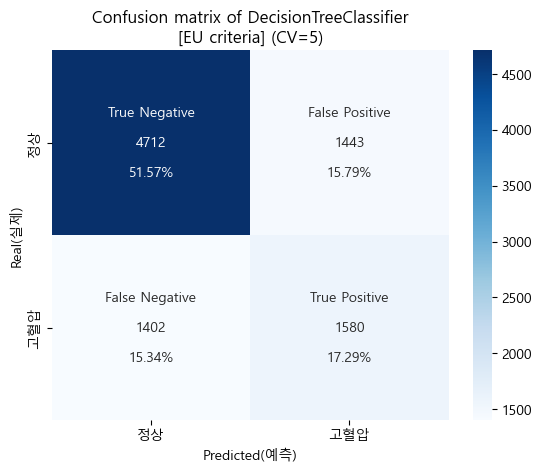

In [43]:
cfm_dtc_eu = confusion_matrix(y_train_eu,CV_pred_dtc_eu)
group_names_dtc_eu = ['True Negative','False Positive','False Negative','True Positive']
group_counts_dtc_eu = ['{0:0.0f}'.format(value) for value in cfm_dtc_eu.flatten()]
group_percentages_dtc_eu = ['{0:.2%}'.format(value) for value in cfm_dtc_eu.flatten()/np.sum(cfm_dtc_eu)]
labels_dtc_eu = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_dtc_eu,group_counts_dtc_eu,group_percentages_dtc_eu)]
labels_dtc_eu = np.asarray(labels_dtc_eu).reshape(2,2)
tick_dtc_eu = ['정상','고혈압']
sns.heatmap(cfm_dtc_eu, annot=labels_dtc_eu, fmt='',cmap='Blues',xticklabels=tick_dtc_eu,yticklabels=tick_dtc_eu)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of DecisionTreeClassifier\n[EU criteria] (CV=5)')
plt.show()

In [44]:
CV_score_accuracy_dtc_eu = cross_val_score(dtc_eu,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='accuracy')
print('[EU criteria]')
print("Baseline accuracy(EU): {}".format(accuracy_score(y_train_eu, baseline_eu)))
print('DecisionTreeClassifier accuracy(EU): {}'.format(CV_score_accuracy_dtc_eu.mean()))

[EU criteria]
Baseline accuracy(EU): 0.6736346722118858
DecisionTreeClassifier accuracy(EU): 0.6886283908165747


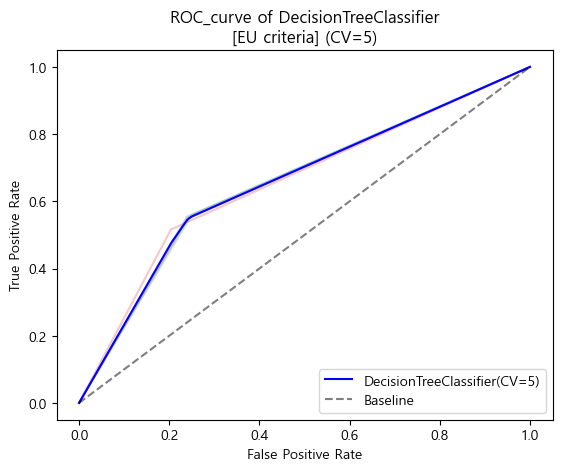

In [45]:
tprs_dtc_eu = []
base_fpr_dtc_eu = np.linspace(0,1,300)

for train_idx, val_idx in kf_5.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_eu_cv, y_val_eu_cv = y_train_eu.iloc[train_idx], y_train_eu.iloc[val_idx]
    
    dtc_eu.fit(X_train_cv,y_train_eu_cv)
    
    y_val_eu_prob = dtc_eu.predict_proba(X_val_cv)[:,1]
    FPR_dtc_eu, TPR_dtc_eu, _ = roc_curve(y_val_eu_cv,y_val_eu_prob)
    
    plt.plot(FPR_dtc_eu,TPR_dtc_eu,alpha=.25)
    tpr_eu = np.interp(base_fpr_dtc_eu,FPR_dtc_eu,TPR_dtc_eu)
    tpr_eu[0] = 0.0
    tprs_dtc_eu.append(tpr_eu)
tprs_dtc_eu = np.array(tprs_dtc_eu)
mean_tprs_dtc_eu = tprs_dtc_eu.mean(axis=0)
plt.plot(base_fpr_dtc_eu,mean_tprs_dtc_eu,label='DecisionTreeClassifier(CV=5)',color='blue')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=.5)
plt.title('ROC_curve of DecisionTreeClassifier\n[EU criteria] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [46]:
CV_score_auc_dtc_eu = cross_val_score(dtc_eu,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='roc_auc')
print('[EU criteria]')
print("Baseline AUC_score(EU): {}".format(roc_auc_score(y_train_eu, baseline_eu)))
print('DecisionTreeClassifier AUC_score(EU) : {}'.format(CV_score_auc_dtc_eu.mean()))

[EU criteria]
Baseline AUC_score(EU): 0.5
DecisionTreeClassifier AUC_score(EU) : 0.64779191985238


#### US & EU

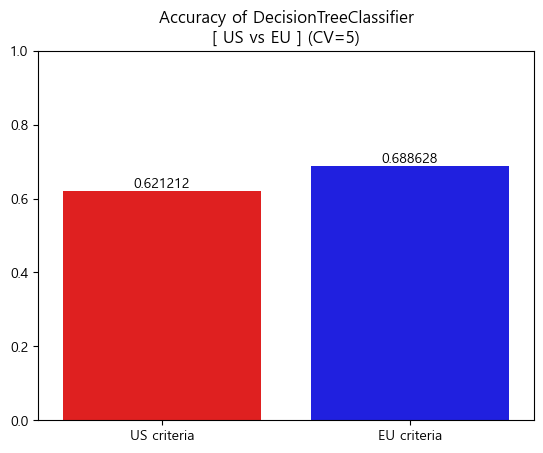

[Accuracy]
DecisionTreeClassifier accuracy(US): 0.6212123879708578
DecisionTreeClassifier accuracy(EU): 0.6886283908165747


In [47]:
df_accuacy_dtc = pd.DataFrame({'US criteria':[CV_score_accuracy_dtc_us.mean()]
                                 ,'EU criteria':[CV_score_accuracy_dtc_eu.mean()]},
                                index=['Accuracy'])
ax = sns.barplot(data=df_accuacy_dtc,palette=['red','blue'])
ax.bar_label(ax.containers[0])
plt.title('Accuracy of DecisionTreeClassifier\n[ US vs EU ] (CV=5)')
plt.ylim(0,1)
plt.show()
print('[Accuracy]')
print('DecisionTreeClassifier accuracy(US): {}'.format(CV_score_accuracy_dtc_us.mean()))
print('DecisionTreeClassifier accuracy(EU): {}'.format(CV_score_accuracy_dtc_eu.mean()))

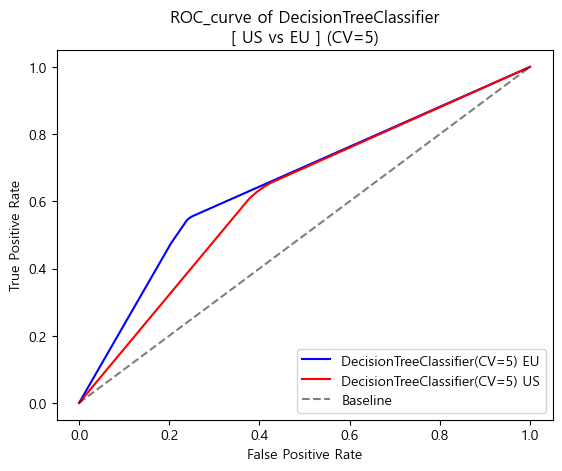

[AUC_score]
DecisionTreeClassifier AUC_score(US) : 0.6209983430921373
DecisionTreeClassifier AUC_score(EU) : 0.64779191985238


In [48]:
plt.plot(base_fpr_dtc_eu,mean_tprs_dtc_eu,label='DecisionTreeClassifier(CV=5) EU',color='blue')
plt.plot(base_fpr_dtc_us,mean_tprs_dtc_us,label='DecisionTreeClassifier(CV=5) US',color='red')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=0.5)
plt.title('ROC_curve of DecisionTreeClassifier\n[ US vs EU ] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print('[AUC_score]')
print('DecisionTreeClassifier AUC_score(US) : {}'.format(CV_score_auc_dtc_us.mean()))
print('DecisionTreeClassifier AUC_score(EU) : {}'.format(CV_score_auc_dtc_eu.mean()))

### 3-3. Random Forest Classifier

#### US criteria

In [49]:
rfc_us = RandomForestClassifier(random_state=42,n_jobs=-1)

rfc_us.fit(X_train,y_train_us)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [50]:
CV_pred_rfc_us = cross_val_predict(rfc_us,X_train,y_train_us,cv=5,n_jobs=-1)
df_rfc_us = pd.DataFrame(data={'y_real_us':y_train_us,
                                 'y_pred_us':CV_pred_rfc_us})
table_rfc_us = pd.crosstab(df_rfc_us['y_real_us'],df_rfc_us['y_pred_us'])
display(table_rfc_us)

y_pred_us     0     1
y_real_us            
0          2890  1491
1          1267  3489

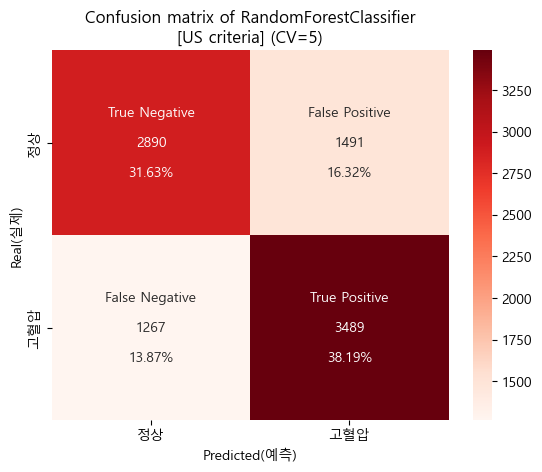

In [51]:
cfm_rfc_us = confusion_matrix(y_train_us,CV_pred_rfc_us)
group_names_rfc_us = ['True Negative','False Positive','False Negative','True Positive']
group_counts_rfc_us = ['{0:0.0f}'.format(value) for value in cfm_rfc_us.flatten()]
group_percentages_rfc_us = ['{0:.2%}'.format(value) for value in cfm_rfc_us.flatten()/np.sum(cfm_rfc_us)]
labels_rfc_us = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_rfc_us,group_counts_rfc_us,group_percentages_rfc_us)]
labels_rfc_us = np.asarray(labels_rfc_us).reshape(2,2)
tick_rfc_us = ['정상','고혈압']
sns.heatmap(cfm_rfc_us, annot=labels_rfc_us, fmt='',cmap='Reds',xticklabels=tick_rfc_us,yticklabels=tick_rfc_us)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of RandomForestClassifier\n[US criteria] (CV=5)')
plt.show()

In [52]:
CV_score_accuracy_rfc_us = cross_val_score(rfc_us,X_train,y_train_us,cv=5,n_jobs=-1,scoring='accuracy')
print('[US criteria]')
print("Baseline accuracy(US): {}".format(accuracy_score(y_train_us, baseline_us)))
print('RandomForestClassifier accuracy(US): {}'.format(CV_score_accuracy_rfc_us.mean()))

[US criteria]
Baseline accuracy(US): 0.5205209587391922
RandomForestClassifier accuracy(US): 0.6981511224173264


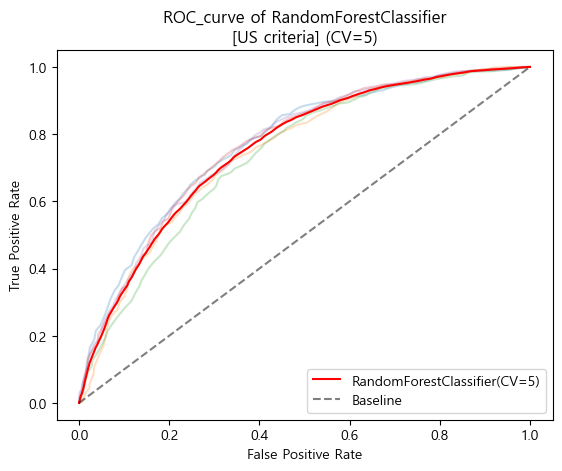

In [53]:
tprs_rfc_us = []
base_fpr_rfc_us = np.linspace(0,1,300)

for train_idx, val_idx in kf_5.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_us_cv, y_val_us_cv = y_train_us.iloc[train_idx], y_train_us.iloc[val_idx]
    
    rfc_us.fit(X_train_cv,y_train_us_cv)
    
    y_val_us_prob = rfc_us.predict_proba(X_val_cv)[:,1]
    FPR_rfc_us, TPR_rfc_us, _ = roc_curve(y_val_us_cv,y_val_us_prob)
    
    plt.plot(FPR_rfc_us,TPR_rfc_us,alpha=.25)
    tpr_us = np.interp(base_fpr_rfc_us,FPR_rfc_us,TPR_rfc_us)
    tpr_us[0] = 0.0
    tprs_rfc_us.append(tpr_us)
tprs_rfc_us = np.array(tprs_rfc_us)
mean_tprs_rfc_us = tprs_rfc_us.mean(axis=0)
plt.plot(base_fpr_rfc_us,mean_tprs_rfc_us,label='RandomForestClassifier(CV=5)',color='red')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=.5)
plt.title('ROC_curve of RandomForestClassifier\n[US criteria] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [54]:
CV_score_auc_rfc_us = cross_val_score(rfc_us,X_train,y_train_us,cv=5,n_jobs=-1,scoring='roc_auc')
print('[US criteria]')
print("Baseline AUC_score(US): {}".format(roc_auc_score(y_train_us, baseline_us)))
print('RandomForestClassifier AUC_score(US) : {}'.format(CV_score_auc_rfc_us.mean()))

[US criteria]
Baseline AUC_score(US): 0.5
RandomForestClassifier AUC_score(US) : 0.7607686634978762


#### EU criteria

In [55]:
rfc_eu = RandomForestClassifier(random_state=42,n_jobs=-1)

rfc_eu.fit(X_train,y_train_eu)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [56]:
CV_pred_rfc_eu = cross_val_predict(rfc_eu,X_train,y_train_eu,cv=5,n_jobs=-1)
df_rfc_eu = pd.DataFrame(data={'y_real_eu':y_train_eu,
                                 'y_pred_eu':CV_pred_rfc_eu})
table_rfc_eu = pd.crosstab(df_rfc_eu['y_real_eu'],df_rfc_eu['y_pred_eu'])
display(table_rfc_eu)

y_pred_eu     0     1
y_real_eu            
0          5179   976
1          1286  1696

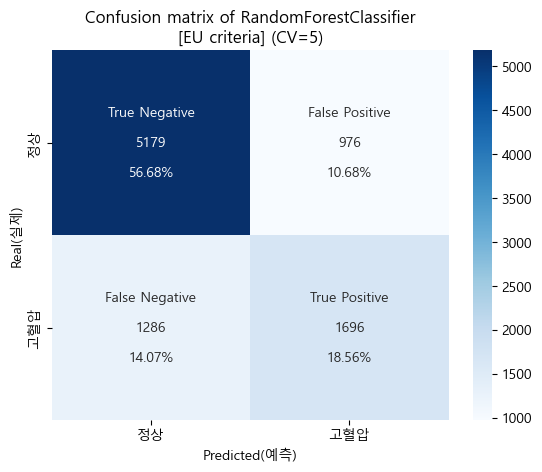

In [57]:
cfm_rfc_eu = confusion_matrix(y_train_eu,CV_pred_rfc_eu)
group_names_rfc_eu = ['True Negative','False Positive','False Negative','True Positive']
group_counts_rfc_eu = ['{0:0.0f}'.format(value) for value in cfm_rfc_eu.flatten()]
group_percentages_rfc_eu = ['{0:.2%}'.format(value) for value in cfm_rfc_eu.flatten()/np.sum(cfm_rfc_eu)]
labels_rfc_eu = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_rfc_eu,group_counts_rfc_eu,group_percentages_rfc_eu)]
labels_rfc_eu = np.asarray(labels_rfc_eu).reshape(2,2)
tick_rfc_eu = ['정상','고혈압']
sns.heatmap(cfm_rfc_eu, annot=labels_rfc_eu, fmt='',cmap='Blues',xticklabels=tick_rfc_eu,yticklabels=tick_rfc_eu)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of RandomForestClassifier\n[EU criteria] (CV=5)')
plt.show()

In [58]:
CV_score_accuracy_rfc_eu = cross_val_score(rfc_eu,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='accuracy')
print('[EU criteria]')
print("Baseline accuracy(EU): {}".format(accuracy_score(y_train_eu, baseline_eu)))
print('RandomForestClassifier accuracy(EU): {}'.format(CV_score_accuracy_rfc_eu.mean()))

[EU criteria]
Baseline accuracy(EU): 0.6736346722118858
RandomForestClassifier accuracy(EU): 0.7524362857645888


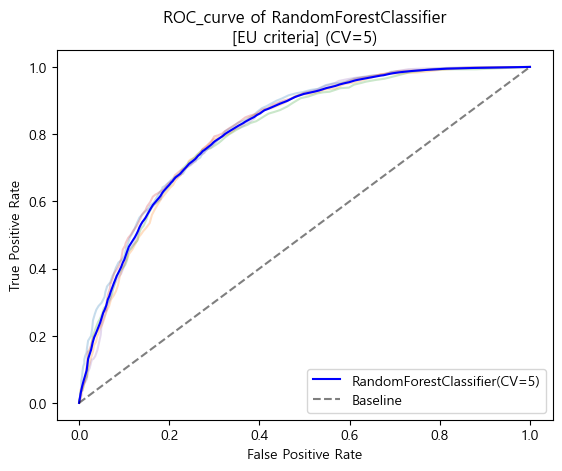

In [59]:
tprs_rfc_eu = []
base_fpr_rfc_eu = np.linspace(0,1,300)

for train_idx, val_idx in kf_5.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_eu_cv, y_val_eu_cv = y_train_eu.iloc[train_idx], y_train_eu.iloc[val_idx]
    
    rfc_eu.fit(X_train_cv,y_train_eu_cv)
    
    y_val_eu_prob = rfc_eu.predict_proba(X_val_cv)[:,1]
    FPR_rfc_eu, TPR_rfc_eu, _ = roc_curve(y_val_eu_cv,y_val_eu_prob)
    
    plt.plot(FPR_rfc_eu,TPR_rfc_eu,alpha=.25)
    tpr_eu = np.interp(base_fpr_rfc_eu,FPR_rfc_eu,TPR_rfc_eu)
    tpr_eu[0] = 0.0
    tprs_rfc_eu.append(tpr_eu)
tprs_rfc_eu = np.array(tprs_rfc_eu)
mean_tprs_rfc_eu = tprs_rfc_eu.mean(axis=0)
plt.plot(base_fpr_rfc_eu,mean_tprs_rfc_eu,label='RandomForestClassifier(CV=5)',color='blue')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=.5)
plt.title('ROC_curve of RandomForestClassifier\n[EU criteria] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [60]:
CV_score_auc_rfc_eu = cross_val_score(rfc_eu,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='roc_auc')
print('[EU criteria]')
print("Baseline AUC_score(EU): {}".format(roc_auc_score(y_train_eu, baseline_eu)))
print('RandomForestClassifier AUC_score(EU) : {}'.format(CV_score_auc_rfc_eu.mean()))

[EU criteria]
Baseline AUC_score(EU): 0.5
RandomForestClassifier AUC_score(EU) : 0.8098352035010266


#### US & EU

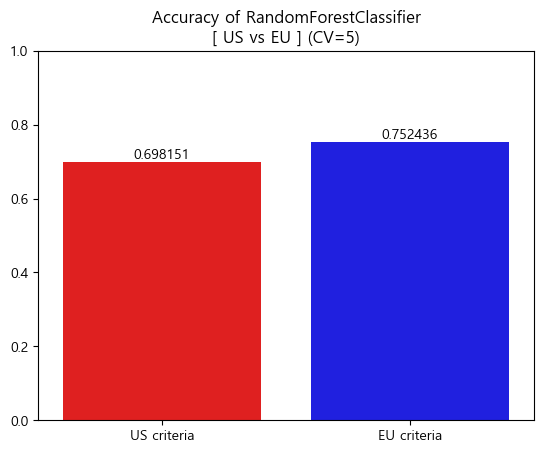

[Accuracy]
RandomForestClassifier accuracy(US): 0.6981511224173264
RandomForestClassifier accuracy(EU): 0.7524362857645888


In [61]:
df_accuacy_rfc = pd.DataFrame({'US criteria':[CV_score_accuracy_rfc_us.mean()]
                                 ,'EU criteria':[CV_score_accuracy_rfc_eu.mean()]},
                                index=['Accuracy'])
ax = sns.barplot(data=df_accuacy_rfc,palette=['red','blue'])
ax.bar_label(ax.containers[0])
plt.title('Accuracy of RandomForestClassifier\n[ US vs EU ] (CV=5)')
plt.ylim(0,1)
plt.show()
print('[Accuracy]')
print('RandomForestClassifier accuracy(US): {}'.format(CV_score_accuracy_rfc_us.mean()))
print('RandomForestClassifier accuracy(EU): {}'.format(CV_score_accuracy_rfc_eu.mean()))

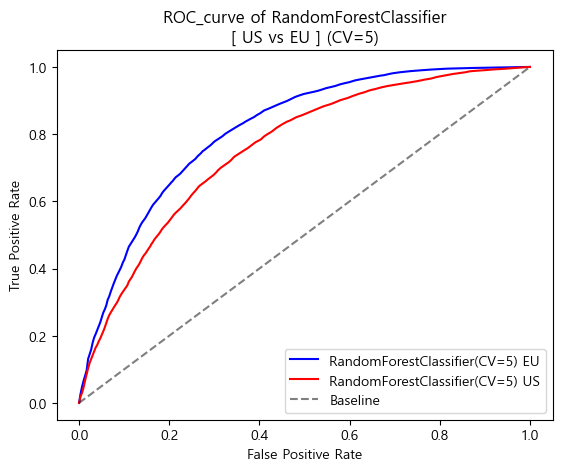

[AUC_score]
RandomForestClassifier AUC_score(US) : 0.7607686634978762
RandomForestClassifier AUC_score(EU) : 0.8098352035010266


In [62]:
plt.plot(base_fpr_rfc_eu,mean_tprs_rfc_eu,label='RandomForestClassifier(CV=5) EU',color='blue')
plt.plot(base_fpr_rfc_us,mean_tprs_rfc_us,label='RandomForestClassifier(CV=5) US',color='red')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=0.5)
plt.title('ROC_curve of RandomForestClassifier\n[ US vs EU ] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print('[AUC_score]')
print('RandomForestClassifier AUC_score(US) : {}'.format(CV_score_auc_rfc_us.mean()))
print('RandomForestClassifier AUC_score(EU) : {}'.format(CV_score_auc_rfc_eu.mean()))

### 3-4. XG Boost Classifier

#### US criteria

In [63]:
xgb_us = XGBClassifier(objective='binary:logistic',
                       eval_metric='auc',
                       random_state=42,n_jobs=-1)

xgb_us.fit(X_train,y_train_us)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [64]:
CV_pred_xgb_us = cross_val_predict(xgb_us,X_train,y_train_us,cv=5,n_jobs=-1)
df_xgb_us = pd.DataFrame(data={'y_real_us':y_train_us,
                                 'y_pred_us':CV_pred_xgb_us})
table_xgb_us = pd.crosstab(df_xgb_us['y_real_us'],df_xgb_us['y_pred_us'])
display(table_xgb_us)

y_pred_us     0     1
y_real_us            
0          2914  1467
1          1273  3483

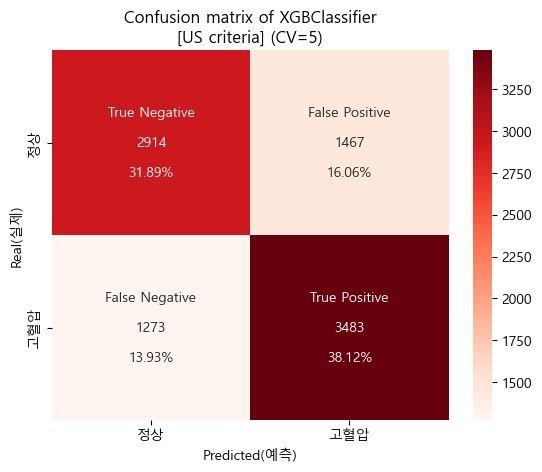

In [65]:
cfm_xgb_us = confusion_matrix(y_train_us,CV_pred_xgb_us)
group_names_xgb_us = ['True Negative','False Positive','False Negative','True Positive']
group_counts_xgb_us = ['{0:0.0f}'.format(value) for value in cfm_xgb_us.flatten()]
group_percentages_xgb_us = ['{0:.2%}'.format(value) for value in cfm_xgb_us.flatten()/np.sum(cfm_xgb_us)]
labels_xgb_us = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_xgb_us,group_counts_xgb_us,group_percentages_xgb_us)]
labels_xgb_us = np.asarray(labels_xgb_us).reshape(2,2)
tick_xgb_us = ['정상','고혈압']
sns.heatmap(cfm_xgb_us, annot=labels_xgb_us, fmt='',cmap='Reds',xticklabels=tick_xgb_us,yticklabels=tick_xgb_us)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of XGBClassifier\n[US criteria] (CV=5)')
plt.show()

In [66]:
CV_score_accuracy_xgb_us = cross_val_score(xgb_us,X_train,y_train_us,cv=5,n_jobs=-1,scoring='accuracy')
print('[US criteria]')
print("Baseline accuracy(US): {}".format(accuracy_score(y_train_us, baseline_us)))
print('XGBClassifier accuracy(US): {}'.format(CV_score_accuracy_xgb_us.mean()))

[US criteria]
Baseline accuracy(US): 0.5205209587391922
XGBClassifier accuracy(US): 0.7001201285363362


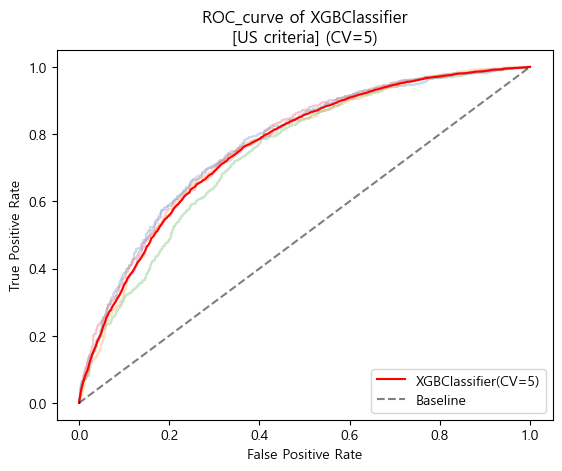

In [67]:
tprs_xgb_us = []
base_fpr_xgb_us = np.linspace(0,1,300)

for train_idx, val_idx in kf_5.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_us_cv, y_val_us_cv = y_train_us.iloc[train_idx], y_train_us.iloc[val_idx]
    
    xgb_us.fit(X_train_cv,y_train_us_cv)
    
    y_val_us_prob = xgb_us.predict_proba(X_val_cv)[:,1]
    FPR_xgb_us, TPR_xgb_us, _ = roc_curve(y_val_us_cv,y_val_us_prob)
    
    plt.plot(FPR_xgb_us,TPR_xgb_us,alpha=.25)
    tpr_us = np.interp(base_fpr_xgb_us,FPR_xgb_us,TPR_xgb_us)
    tpr_us[0] = 0.0
    tprs_xgb_us.append(tpr_us)
tprs_xgb_us = np.array(tprs_xgb_us)
mean_tprs_xgb_us = tprs_xgb_us.mean(axis=0)
plt.plot(base_fpr_xgb_us,mean_tprs_xgb_us,label='XGBClassifier(CV=5)',color='red')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=.5)
plt.title('ROC_curve of XGBClassifier\n[US criteria] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [68]:
CV_score_auc_xgb_us = cross_val_score(xgb_us,X_train,y_train_us,cv=5,n_jobs=-1,scoring='roc_auc')
print('[US criteria]')
print("Baseline AUC_score(US): {}".format(roc_auc_score(y_train_us, baseline_us)))
print('XGBClassifier AUC_score(US) : {}'.format(CV_score_auc_xgb_us.mean()))

[US criteria]
Baseline AUC_score(US): 0.5
XGBClassifier AUC_score(US) : 0.7607539893215014


#### EU criteria

In [69]:
xgb_eu = XGBClassifier(objective='binary:logistic',
                       eval_metric='auc',
                       random_state=42,n_jobs=-1)

xgb_eu.fit(X_train,y_train_eu)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [70]:
CV_pred_xgb_eu = cross_val_predict(xgb_eu,X_train,y_train_eu,cv=5,n_jobs=-1)
df_xgb_eu = pd.DataFrame(data={'y_real_eu':y_train_eu,
                                 'y_pred_eu':CV_pred_xgb_eu})
table_xgb_eu = pd.crosstab(df_xgb_eu['y_real_eu'],df_xgb_eu['y_pred_eu'])
display(table_xgb_eu)

y_pred_eu     0     1
y_real_eu            
0          5119  1036
1          1260  1722

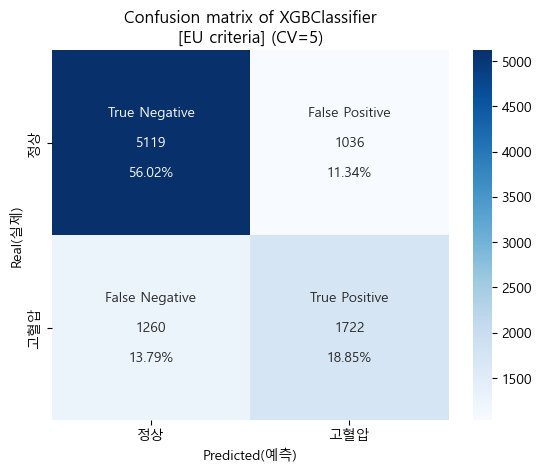

In [71]:
cfm_xgb_eu = confusion_matrix(y_train_eu,CV_pred_xgb_eu)
group_names_xgb_eu = ['True Negative','False Positive','False Negative','True Positive']
group_counts_xgb_eu = ['{0:0.0f}'.format(value) for value in cfm_xgb_eu.flatten()]
group_percentages_xgb_eu = ['{0:.2%}'.format(value) for value in cfm_xgb_eu.flatten()/np.sum(cfm_xgb_eu)]
labels_xgb_eu = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_xgb_eu,group_counts_xgb_eu,group_percentages_xgb_eu)]
labels_xgb_eu = np.asarray(labels_xgb_eu).reshape(2,2)
tick_xgb_eu = ['정상','고혈압']
sns.heatmap(cfm_xgb_eu, annot=labels_xgb_eu, fmt='',cmap='Blues',xticklabels=tick_xgb_eu,yticklabels=tick_xgb_eu)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of XGBClassifier\n[EU criteria] (CV=5)')
plt.show()

In [72]:
CV_score_accuracy_xgb_eu = cross_val_score(xgb_eu,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='accuracy')
print('[EU criteria]')
print("Baseline accuracy(EU): {}".format(accuracy_score(y_train_eu, baseline_eu)))
print('XGBClassifier accuracy(EU): {}'.format(CV_score_accuracy_xgb_eu.mean()))

[EU criteria]
Baseline accuracy(EU): 0.6736346722118858
XGBClassifier accuracy(EU): 0.7487126005612386


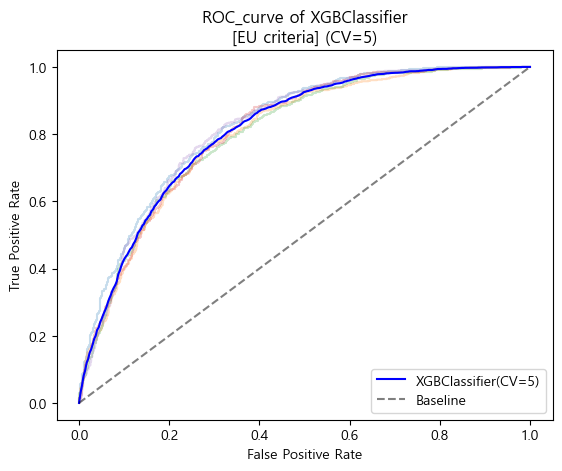

In [73]:
tprs_xgb_eu = []
base_fpr_xgb_eu = np.linspace(0,1,300)

for train_idx, val_idx in kf_5.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_eu_cv, y_val_eu_cv = y_train_eu.iloc[train_idx], y_train_eu.iloc[val_idx]
    
    xgb_eu.fit(X_train_cv,y_train_eu_cv)
    
    y_val_eu_prob = xgb_eu.predict_proba(X_val_cv)[:,1]
    FPR_xgb_eu, TPR_xgb_eu, _ = roc_curve(y_val_eu_cv,y_val_eu_prob)
    
    plt.plot(FPR_xgb_eu,TPR_xgb_eu,alpha=.25)
    tpr_eu = np.interp(base_fpr_xgb_eu,FPR_xgb_eu,TPR_xgb_eu)
    tpr_eu[0] = 0.0
    tprs_xgb_eu.append(tpr_eu)
tprs_xgb_eu = np.array(tprs_xgb_eu)
mean_tprs_xgb_eu = tprs_xgb_eu.mean(axis=0)
plt.plot(base_fpr_xgb_eu,mean_tprs_xgb_eu,label='XGBClassifier(CV=5)',color='blue')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=.5)
plt.title('ROC_curve of XGBClassifier\n[EU criteria] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [74]:
CV_score_auc_xgb_eu = cross_val_score(xgb_eu,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='roc_auc')
print('[EU criteria]')
print("Baseline AUC_score(EU): {}".format(roc_auc_score(y_train_eu, baseline_eu)))
print('XGBClassifier AUC_score(EU) : {}'.format(CV_score_auc_xgb_eu.mean()))

[EU criteria]
Baseline AUC_score(EU): 0.5
XGBClassifier AUC_score(EU) : 0.8083638731971957


#### US & EU

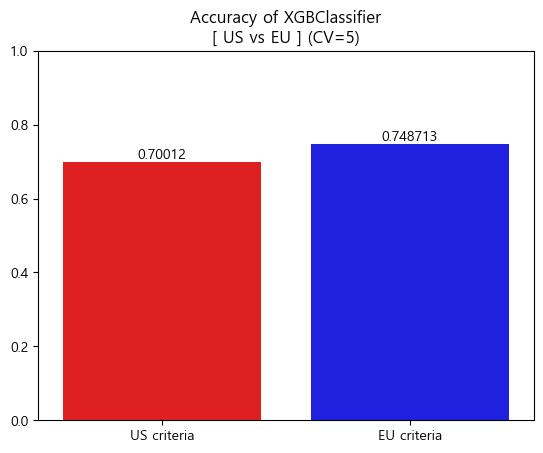

[Accuracy]
XGBClassifier accuracy(US): 0.7001201285363362
XGBClassifier accuracy(EU): 0.7487126005612386


In [75]:
df_accuacy_xgb = pd.DataFrame({'US criteria':[CV_score_accuracy_xgb_us.mean()]
                                 ,'EU criteria':[CV_score_accuracy_xgb_eu.mean()]},
                                index=['Accuracy'])
ax = sns.barplot(data=df_accuacy_xgb,palette=['red','blue'])
ax.bar_label(ax.containers[0])
plt.title('Accuracy of XGBClassifier\n[ US vs EU ] (CV=5)')
plt.ylim(0,1)
plt.show()
print('[Accuracy]')
print('XGBClassifier accuracy(US): {}'.format(CV_score_accuracy_xgb_us.mean()))
print('XGBClassifier accuracy(EU): {}'.format(CV_score_accuracy_xgb_eu.mean()))

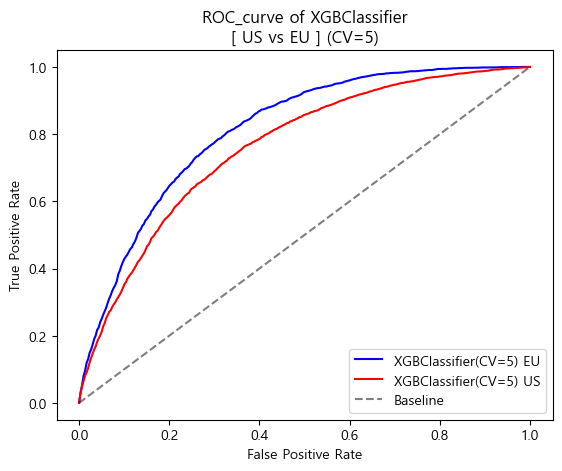

[AUC_score]
XGBClassifier AUC_score(US) : 0.7607539893215014
XGBClassifier AUC_score(EU) : 0.8083638731971957


In [76]:
plt.plot(base_fpr_xgb_eu,mean_tprs_xgb_eu,label='XGBClassifier(CV=5) EU',color='blue')
plt.plot(base_fpr_xgb_us,mean_tprs_xgb_us,label='XGBClassifier(CV=5) US',color='red')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=0.5)
plt.title('ROC_curve of XGBClassifier\n[ US vs EU ] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print('[AUC_score]')
print('XGBClassifier AUC_score(US) : {}'.format(CV_score_auc_xgb_us.mean()))
print('XGBClassifier AUC_score(EU) : {}'.format(CV_score_auc_xgb_eu.mean()))

### Comparing models evaluation scores

#### US criteria

In [77]:
df_score_us = pd.DataFrame({'Accuracy':[accuracy_score(y_train_us, baseline_us),
                                        CV_score_accuracy_logis_us.mean(),
                                        CV_score_accuracy_dtc_us.mean(),
                                        CV_score_accuracy_rfc_us.mean(),
                                        CV_score_accuracy_xgb_us.mean()],
                            'AUC_score':[roc_auc_score(y_train_us, baseline_us),
                                       CV_score_auc_logis_us.mean(),
                                       CV_score_auc_dtc_us.mean(),
                                       CV_score_auc_rfc_us.mean(),
                                       CV_score_auc_xgb_us.mean()]},
                           index = ['Baseline','Logistic','DecisionTree','RandomForest','XGBoost']).sort_values(by='AUC_score',ascending=False)
df_score_us

Accuracy  AUC_score
Logistic      0.724090   0.791179
RandomForest  0.698151   0.760769
XGBoost       0.700120   0.760754
DecisionTree  0.621212   0.620998
Baseline      0.520521   0.500000

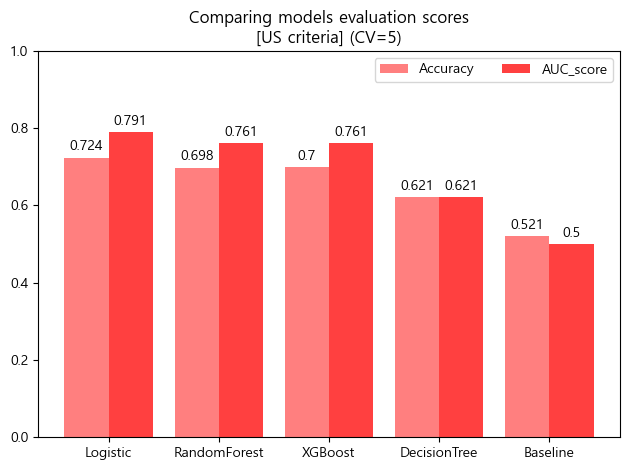

In [78]:
x = np.arange(5)
width = 0.4

fig, ax = plt.subplots()
rect1 = ax.bar(x-width/2, df_score_us.Accuracy.round(3), width, label='Accuracy',color='red',alpha=0.5)
rect2 = ax.bar(x+width/2, df_score_us.AUC_score.round(3), width, label='AUC_score',color='red',alpha=0.75)

ax.set_title('Comparing models evaluation scores\n[US criteria] (CV=5)')
ax.set_xticks(x, df_score_us.index)
ax.bar_label(rect1, padding=3)
ax.bar_label(rect2, padding=3)

fig.tight_layout()

plt.ylim([0,1])
plt.legend(ncol=2)
plt.show()

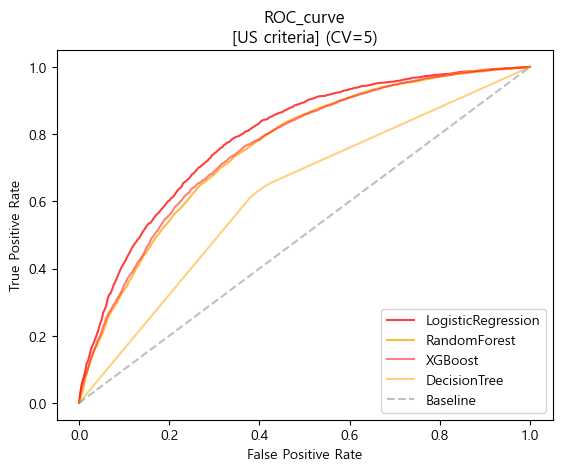

In [79]:
plt.plot(base_fpr_logis_us,mean_tprs_logis_us,label='LogisticRegression',color='red',alpha=0.75)
plt.plot(base_fpr_rfc_us,mean_tprs_rfc_us,label='RandomForest',color='orange',alpha=0.75)
plt.plot(base_fpr_xgb_us,mean_tprs_xgb_us,label='XGBoost',color='red',alpha=0.5)
plt.plot(base_fpr_dtc_us,mean_tprs_dtc_us,label='DecisionTree',color='orange',alpha=0.5)
plt.plot([0,1],[0,1],label='Baseline',color='gray',linestyle='--',alpha=0.5)
plt.title('ROC_curve\n[US criteria] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

#### EU criteria

In [80]:
df_score_eu = pd.DataFrame({'Accuracy':[accuracy_score(y_train_eu, baseline_eu),
                                        CV_score_accuracy_logis_eu.mean(),
                                        CV_score_accuracy_dtc_eu.mean(),
                                        CV_score_accuracy_rfc_eu.mean(),
                                        CV_score_accuracy_xgb_eu.mean()],
                            'AUC_score':[roc_auc_score(y_train_eu, baseline_eu),
                                       CV_score_auc_logis_eu.mean(),
                                       CV_score_auc_dtc_eu.mean(),
                                       CV_score_auc_rfc_eu.mean(),
                                       CV_score_auc_xgb_eu.mean()]},
                           index = ['Baseline','Logistic','DecisionTree','RandomForest','XGBoost']).sort_values(by='AUC_score',ascending=False)
df_score_eu

Accuracy  AUC_score
Logistic      0.769618   0.837712
RandomForest  0.752436   0.809835
XGBoost       0.748713   0.808364
DecisionTree  0.688628   0.647792
Baseline      0.673635   0.500000

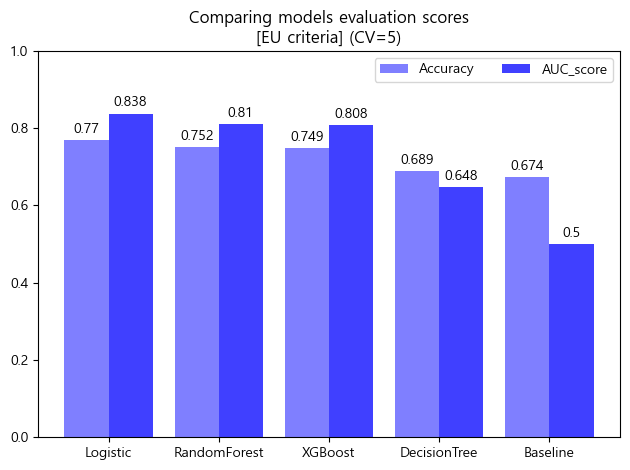

In [81]:
x = np.arange(5)
width = 0.4

fig, ax = plt.subplots()
rect1 = ax.bar(x-width/2, df_score_eu.Accuracy.round(3), width, label='Accuracy',color='blue',alpha=0.5)
rect2 = ax.bar(x+width/2, df_score_eu.AUC_score.round(3), width, label='AUC_score',color='blue',alpha=0.75)

ax.set_title('Comparing models evaluation scores\n[EU criteria] (CV=5)')
ax.set_xticks(x, df_score_eu.index)
ax.bar_label(rect1, padding=3)
ax.bar_label(rect2, padding=3)

fig.tight_layout()

plt.ylim([0,1])
plt.legend(ncol=2)
plt.show()

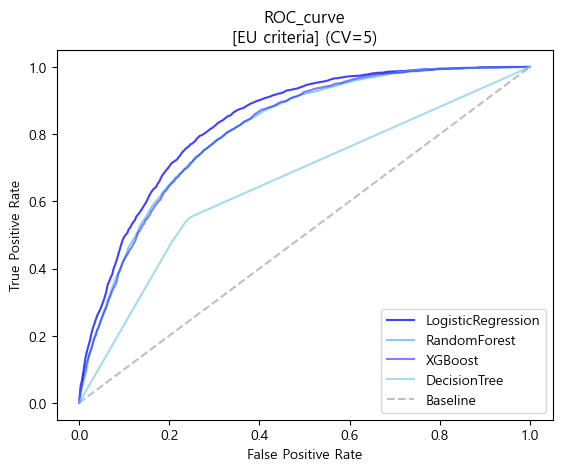

In [82]:
plt.plot(base_fpr_logis_eu,mean_tprs_logis_eu,label='LogisticRegression',color='blue',alpha=0.75)
plt.plot(base_fpr_rfc_eu,mean_tprs_rfc_eu,label='RandomForest',color='skyblue',alpha=1)
plt.plot(base_fpr_xgb_eu,mean_tprs_xgb_eu,label='XGBoost',color='blue',alpha=0.5)
plt.plot(base_fpr_dtc_eu,mean_tprs_dtc_eu,label='DecisionTree',color='skyblue',alpha=0.75)
plt.plot([0,1],[0,1],label='Baseline',color='gray',linestyle='--',alpha=0.5)
plt.title('ROC_curve\n[EU criteria] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

#### US & EU

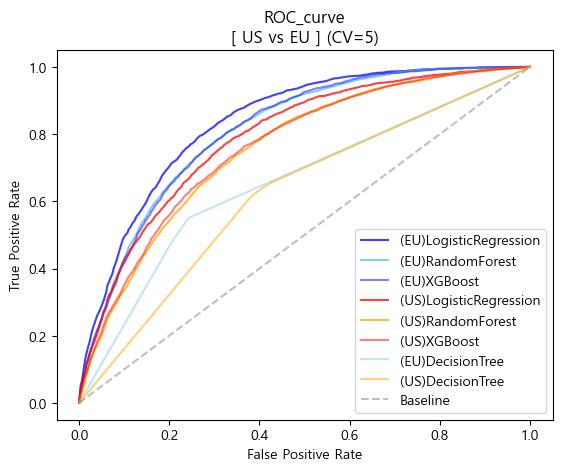

In [83]:
plt.plot(base_fpr_logis_eu,mean_tprs_logis_eu,label='(EU)LogisticRegression',color='blue',alpha=0.75)
plt.plot(base_fpr_rfc_eu,mean_tprs_rfc_eu,label='(EU)RandomForest',color='skyblue',alpha=1)
plt.plot(base_fpr_xgb_eu,mean_tprs_xgb_eu,label='(EU)XGBoost',color='blue',alpha=0.5)
plt.plot(base_fpr_logis_us,mean_tprs_logis_us,label='(US)LogisticRegression',color='red',alpha=0.75)
plt.plot(base_fpr_rfc_us,mean_tprs_rfc_us,label='(US)RandomForest',color='orange',alpha=0.75)
plt.plot(base_fpr_xgb_us,mean_tprs_xgb_us,label='(US)XGBoost',color='red',alpha=0.5)
plt.plot(base_fpr_dtc_eu,mean_tprs_dtc_eu,label='(EU)DecisionTree',color='skyblue',alpha=0.5)
plt.plot(base_fpr_dtc_us,mean_tprs_dtc_us,label='(US)DecisionTree',color='orange',alpha=0.5)
plt.plot([0,1],[0,1],label='Baseline',color='gray',linestyle='--',alpha=0.5)
plt.title('ROC_curve\n[ US vs EU ] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## 4. Modeling (Hyperparameter Tuning)

### 4-1. Logistic Regression (GridSearch CV)

#### Hyperparameter Tuning (GridSearch CV)

In [84]:
print(pipe_logis_us)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])


In [85]:
param_logis = {
    'logisticregression__C':np.logspace(-4,4,50),
    'logisticregression__max_iter':[5,10,50,100,500],
}

In [86]:
gs_logis_us = GridSearchCV(estimator=pipe_logis_us,
                           param_grid=param_logis,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
gs_logis_us.fit(X_train_log,y_train_us)
print("최적 하이퍼파라미터: ", gs_logis_us.best_params_)
print("최적 roc_auc: ", gs_logis_us.best_score_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
최적 하이퍼파라미터:  {'logisticregression__C': 109.85411419875572, 'logisticregression__max_iter': 50}
최적 roc_auc:  0.7913023297179961


In [87]:
gs_logis_eu = GridSearchCV(estimator=pipe_logis_eu,
                           param_grid=param_logis,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
gs_logis_eu.fit(X_train_log,y_train_eu)
print("최적 하이퍼파라미터: ", gs_logis_eu.best_params_)
print("최적 roc_auc: ", gs_logis_eu.best_score_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
최적 하이퍼파라미터:  {'logisticregression__C': 1048.1131341546852, 'logisticregression__max_iter': 50}
최적 roc_auc:  0.8378130078057723


#### Modeling(Tuning)

In [88]:
pipe_logis_us_tun = make_pipeline(
    MinMaxScaler(),
    LogisticRegression(C=109.85411419875572,
                       max_iter=50)
)
pipe_logis_us_tun.fit(X_train_log,y_train_us)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=109.85411419875572, max_iter=50))])

In [89]:
CV_score_accuracy_logis_us_tun = cross_val_score(pipe_logis_us_tun,X_train_log,y_train_us,cv=5,n_jobs=-1,scoring='accuracy')
CV_score_auc_logis_us_tun = cross_val_score(pipe_logis_us_tun,X_train_log,y_train_us,cv=5,n_jobs=-1,scoring='roc_auc')
print('[US criteria]')
print('LogisticRegression accuracy(Before): {}'.format(CV_score_accuracy_logis_us.mean()))
print('LogisticRegression accuracy(After): {}'.format(CV_score_accuracy_logis_us_tun.mean()))
print('LogisticRegression AUC_score(Before) : {}'.format(CV_score_auc_logis_us.mean()))
print('LogisticRegression AUC_score(After) : {}'.format(CV_score_auc_logis_us_tun.mean()))

[US criteria]
LogisticRegression accuracy(Before): 0.7240900832276369
LogisticRegression accuracy(After): 0.723761676002678
LogisticRegression AUC_score(Before) : 0.7911785348771734
LogisticRegression AUC_score(After) : 0.7913023297179961


In [90]:
pipe_logis_eu_tun = make_pipeline(
    MinMaxScaler(),
    LogisticRegression(C=1048.1131341546852,
                       max_iter=50)
)
pipe_logis_eu_tun.fit(X_train_log,y_train_eu)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=1048.1131341546852, max_iter=50))])

In [91]:
CV_score_accuracy_logis_eu_tun = cross_val_score(pipe_logis_eu_tun,X_train_log,y_train_eu,cv=5,n_jobs=-1,scoring='accuracy')
CV_score_auc_logis_eu_tun = cross_val_score(pipe_logis_eu_tun,X_train_log,y_train_eu,cv=5,n_jobs=-1,scoring='roc_auc')
print('[EU criteria]')
print('LogisticRegression accuracy(Before): {}'.format(CV_score_accuracy_logis_eu.mean()))
print('LogisticRegression accuracy(After): {}'.format(CV_score_accuracy_logis_eu_tun.mean()))
print('LogisticRegression AUC_score(Before) : {}'.format(CV_score_auc_logis_eu.mean()))
print('LogisticRegression AUC_score(After) : {}'.format(CV_score_auc_logis_eu_tun.mean()))

[EU criteria]
LogisticRegression accuracy(Before): 0.7696176606913798
LogisticRegression accuracy(After): 0.7703840041008985
LogisticRegression AUC_score(Before) : 0.8377120074901867
LogisticRegression AUC_score(After) : 0.8378130078057723


### 4-2. Random Forest Classifier (Grid Search CV)

#### Hyperparameter Tuning (GridSearch CV)

In [92]:
print(rfc_us)

RandomForestClassifier(n_jobs=-1, random_state=42)


In [93]:
param_rfc = {
    'criterion':['entropy'],
    'max_depth':[5,10,20],
    'min_samples_leaf':[2,4,8],
    'min_samples_split':[2,4,8],
    'n_estimators': [500],
    'max_features': ['sqrt']
}

In [94]:
gs_rfc_us = GridSearchCV(estimator=rfc_us,
                           param_grid=param_rfc,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
gs_rfc_us.fit(X_train,y_train_us)
print("최적 하이퍼파라미터: ", gs_rfc_us.best_params_)
print("최적 roc_auc: ", gs_rfc_us.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
최적 하이퍼파라미터:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 500}
최적 roc_auc:  0.7895306195617645


In [95]:
gs_rfc_eu = GridSearchCV(estimator=rfc_eu,
                           param_grid=param_rfc,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
gs_rfc_eu.fit(X_train,y_train_eu)
print("최적 하이퍼파라미터: ", gs_rfc_eu.best_params_)
print("최적 roc_auc: ", gs_rfc_eu.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
최적 하이퍼파라미터:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 500}
최적 roc_auc:  0.8340516260638484


#### Modeling(Tuning)

In [96]:
rfc_us_tun = RandomForestClassifier(
    n_jobs=-1,
    random_state=42,
    criterion='entropy',
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=8,
    min_samples_split=2,
    n_estimators=500,
)

rfc_us_tun.fit(X_train,y_train_us)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=8,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [97]:
CV_score_accuracy_rfc_us_tun = cross_val_score(rfc_us_tun,X_train,y_train_us,cv=5,n_jobs=-1,scoring='accuracy')
CV_score_auc_rfc_us_tun = cross_val_score(rfc_us_tun,X_train,y_train_us,cv=5,n_jobs=-1,scoring='roc_auc')
print('[US criteria]')
print('RandomForestClassifier accuracy(Before): {}'.format(CV_score_accuracy_rfc_us.mean()))
print('RandomForestClassifier accuracy(After): {}'.format(CV_score_accuracy_rfc_us_tun.mean()))
print('RandomForestClassifier AUC_score(Before) : {}'.format(CV_score_auc_rfc_us.mean()))
print('RandomForestClassifier AUC_score(After) : {}'.format(CV_score_auc_rfc_us_tun.mean()))

[US criteria]
RandomForestClassifier accuracy(Before): 0.6981511224173264
RandomForestClassifier accuracy(After): 0.7239809734603366
RandomForestClassifier AUC_score(Before) : 0.7607686634978762
RandomForestClassifier AUC_score(After) : 0.7895306195617645


In [98]:
rfc_eu_tun = RandomForestClassifier(
    n_jobs=-1,
    random_state=42,
    criterion='entropy',
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=8,
    min_samples_split=2,
    n_estimators=500,
)

rfc_eu_tun.fit(X_train,y_train_eu)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=8,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [99]:
CV_score_accuracy_rfc_eu_tun = cross_val_score(rfc_eu_tun,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='accuracy')
CV_score_auc_rfc_eu_tun = cross_val_score(rfc_eu_tun,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='roc_auc')
print('[EU criteria]')
print('RandomForestClassifier accuracy(Before): {}'.format(CV_score_accuracy_rfc_eu.mean()))
print('RandomForestClassifier accuracy(After): {}'.format(CV_score_accuracy_rfc_eu_tun.mean()))
print('RandomForestClassifier AUC_score(Before) : {}'.format(CV_score_auc_rfc_eu.mean()))
print('RandomForestClassifier AUC_score(After) : {}'.format(CV_score_auc_rfc_eu_tun.mean()))

[EU criteria]
RandomForestClassifier accuracy(Before): 0.7524362857645888
RandomForestClassifier accuracy(After): 0.7720256809180073
RandomForestClassifier AUC_score(Before) : 0.8098352035010266
RandomForestClassifier AUC_score(After) : 0.8340516260638484


### 4-3. XG Boost (Grid SearchCV)

#### Hyperparameter Tuning (GridSearch CV)

In [100]:
print(xgb_us)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)


In [101]:
param_xgb = {
    'objective':['binary:logistic'],
    'eval_metric':['auc'],
    'n_estimators':[200],
    'learning_rate':[0.05],
    'max_depth':[2,3,4],
    'min_child_weight':[4,8,16,32],
    'subsample':[0.2,0.3,0.4,0.5],
    'colsample_bytree':[0.7,0.8,0.9]
}

In [102]:
gs_xgb_us = GridSearchCV(estimator=xgb_us,
                           param_grid=param_xgb,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
gs_xgb_us.fit(X_train,y_train_us)
print("최적 하이퍼파라미터: ", gs_xgb_us.best_params_)
print("최적 roc_auc: ", gs_xgb_us.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
최적 하이퍼파라미터:  {'colsample_bytree': 0.8, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 0.2}
최적 roc_auc:  0.794148446162498


In [103]:
gs_xgb_eu = GridSearchCV(estimator=xgb_eu,
                           param_grid=param_xgb,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
gs_xgb_eu.fit(X_train,y_train_eu)
print("최적 하이퍼파라미터: ", gs_xgb_eu.best_params_)
print("최적 roc_auc: ", gs_xgb_eu.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
최적 하이퍼파라미터:  {'colsample_bytree': 0.9, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 8, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 0.3}
최적 roc_auc:  0.8380314251605574


#### Modeling(Tuning)

In [104]:
xgb_us_tun = XGBClassifier(
    n_jobs = -1,
    random_state = 42,
    objective = 'binary:logistic',
    eval_metric = 'auc',
    n_estimators = 200,
    learning_rate = 0.05,
    max_depth = 2,
    min_child_weight = 4,
    subsample = 0.2,
    colsample_bytree = 0.8
)

xgb_us_tun.fit(X_train,y_train_us)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=4,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [105]:
CV_score_accuracy_xgb_us_tun = cross_val_score(xgb_us_tun,X_train,y_train_us,cv=5,n_jobs=-1,scoring='accuracy')
CV_score_auc_xgb_us_tun = cross_val_score(xgb_us_tun,X_train,y_train_us,cv=5,n_jobs=-1,scoring='roc_auc')
print('[US criteria]')
print('XGBClassifier accuracy(Before): {}'.format(CV_score_accuracy_xgb_us.mean()))
print('XGBClassifier accuracy(After): {}'.format(CV_score_accuracy_xgb_us_tun.mean()))
print('XGBClassifier AUC_score(Before) : {}'.format(CV_score_auc_xgb_us.mean()))
print('XGBClassifier AUC_score(After) : {}'.format(CV_score_auc_xgb_us_tun.mean()))

[US criteria]
XGBClassifier accuracy(Before): 0.7001201285363362
XGBClassifier accuracy(After): 0.7275927343195132
XGBClassifier AUC_score(Before) : 0.7607539893215014
XGBClassifier AUC_score(After) : 0.794148446162498


In [106]:
xgb_eu_tun = XGBClassifier(
    n_jobs = -1,
    random_state = 42,
    objective = 'binary:logistic',
    eval_metric = 'auc',
    n_estimators = 200,
    learning_rate = 0.05,
    max_depth = 2,
    min_child_weight = 8,
    subsample = 0.3,
    colsample_bytree = 0.9
)

xgb_eu_tun.fit(X_train,y_train_eu)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=8,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [107]:
CV_score_accuracy_xgb_eu_tun = cross_val_score(xgb_eu_tun,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='accuracy')
CV_score_auc_xgb_eu_tun = cross_val_score(xgb_eu_tun,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='roc_auc')
print('[EU criteria]')
print('XGBClassifier accuracy(Before): {}'.format(CV_score_accuracy_xgb_eu.mean()))
print('XGBClassifier accuracy(After): {}'.format(CV_score_accuracy_xgb_eu_tun.mean()))
print('XGBClassifier AUC_score(Before) : {}'.format(CV_score_auc_xgb_eu.mean()))
print('XGBClassifier AUC_score(After) : {}'.format(CV_score_auc_xgb_eu_tun.mean()))

[EU criteria]
XGBClassifier accuracy(Before): 0.7487126005612386
XGBClassifier accuracy(After): 0.7719166310353212
XGBClassifier AUC_score(Before) : 0.8083638731971957
XGBClassifier AUC_score(After) : 0.8380314251605574


### Comparing Tuning models evaluation score

In [108]:
df_score_us_tun = pd.DataFrame({'Before_accuarcy':[CV_score_accuracy_logis_us.mean(),
                                      CV_score_accuracy_rfc_us.mean(),
                                      CV_score_accuracy_xgb_us.mean()],
                                'After_accuarcy':[CV_score_accuracy_logis_us_tun.mean(),
                                     CV_score_accuracy_rfc_us_tun.mean(),
                                     CV_score_accuracy_xgb_us_tun.mean()],
                                'Before_AUC':[CV_score_auc_logis_us.mean(),
                                      CV_score_auc_rfc_us.mean(),
                                      CV_score_auc_xgb_us.mean()],
                                'After_AUC':[CV_score_auc_logis_us_tun.mean(),
                                     CV_score_auc_rfc_us_tun.mean(),
                                     CV_score_auc_xgb_us_tun.mean()]},
                           index = ['Logistic','RandomForest','XGBoost']).sort_values(by='After_AUC',ascending=False)
df_score_us_tun

Before_accuarcy  After_accuarcy  Before_AUC  After_AUC
XGBoost              0.700120        0.727593    0.760754   0.794148
Logistic             0.724090        0.723762    0.791179   0.791302
RandomForest         0.698151        0.723981    0.760769   0.789531

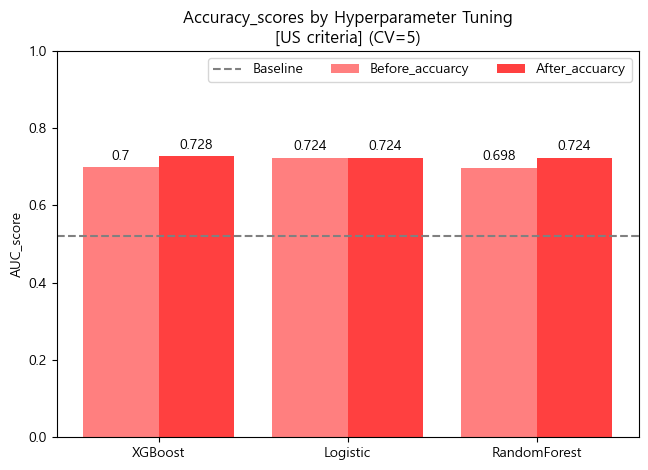

In [109]:
x = np.arange(3)
width = 0.4

fig, ax = plt.subplots()
rect1 = ax.bar(x-width/2, df_score_us_tun.Before_accuarcy.round(3), width, label='Before_accuarcy',color='red',alpha=0.5)
rect2 = ax.bar(x+width/2, df_score_us_tun.After_accuarcy.round(3), width, label='After_accuarcy',color='red',alpha=0.75)

ax.set_title('Accuracy_scores by Hyperparameter Tuning\n[US criteria] (CV=5)')
ax.set_xticks(x, df_score_us_tun.index)
ax.bar_label(rect1, padding=3)
ax.bar_label(rect2, padding=3)

fig.tight_layout()

plt.axhline(accuracy_score(y_train_us, baseline_us),color='gray',linestyle='--',label='Baseline')
plt.ylabel('AUC_score')
plt.ylim([0,1])
plt.legend(ncol=3)
plt.show()

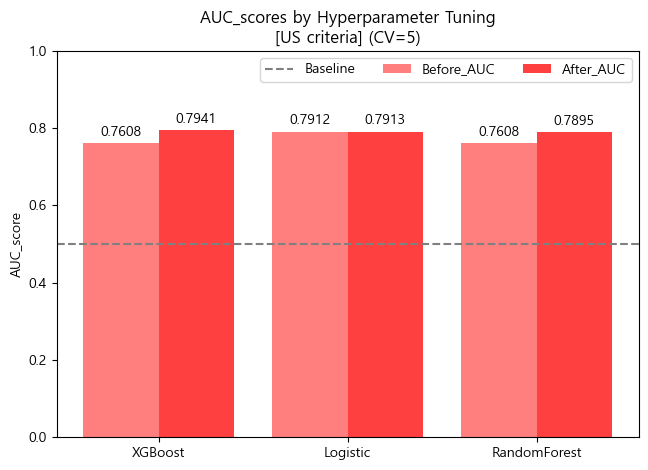

In [110]:
x = np.arange(3)
width = 0.4

fig, ax = plt.subplots()
rect1 = ax.bar(x-width/2, df_score_us_tun.Before_AUC.round(4), width, label='Before_AUC',color='red',alpha=0.5)
rect2 = ax.bar(x+width/2, df_score_us_tun.After_AUC.round(4), width, label='After_AUC',color='red',alpha=0.75)

ax.set_title('AUC_scores by Hyperparameter Tuning\n[US criteria] (CV=5)')
ax.set_xticks(x, df_score_us_tun.index)
ax.bar_label(rect1, padding=3)
ax.bar_label(rect2, padding=3)

fig.tight_layout()

plt.axhline(.5,color='gray',linestyle='--',label='Baseline')
plt.ylabel('AUC_score')
plt.ylim([0,1])
plt.legend(ncol=3)
plt.show()

In [112]:
df_score_eu_tun = pd.DataFrame({'Before_accuarcy':[CV_score_accuracy_logis_eu.mean(),
                                      CV_score_accuracy_rfc_eu.mean(),
                                      CV_score_accuracy_xgb_eu.mean()],
                                'After_accuarcy':[CV_score_accuracy_logis_eu_tun.mean(),
                                     CV_score_accuracy_rfc_eu_tun.mean(),
                                     CV_score_accuracy_xgb_eu_tun.mean()],
                                'Before_AUC':[CV_score_auc_logis_eu.mean(),
                                      CV_score_auc_rfc_eu.mean(),
                                      CV_score_auc_xgb_eu.mean()],
                                'After_AUC':[CV_score_auc_logis_eu_tun.mean(),
                                     CV_score_auc_rfc_eu_tun.mean(),
                                     CV_score_auc_xgb_eu_tun.mean()]},
                           index = ['Logistic','RandomForest','XGBoost']).sort_values(by='After_AUC',ascending=False)
df_score_eu_tun

Before_accuarcy  After_accuarcy  Before_AUC  After_AUC
XGBoost              0.748713        0.771917    0.808364   0.838031
Logistic             0.769618        0.770384    0.837712   0.837813
RandomForest         0.752436        0.772026    0.809835   0.834052

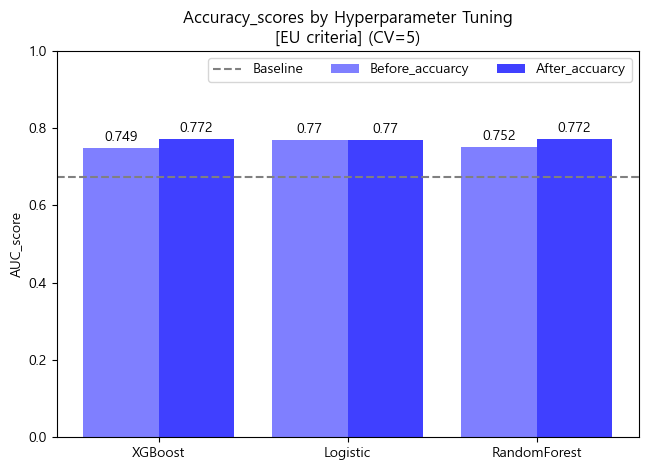

In [113]:
x = np.arange(3)
width = 0.4

fig, ax = plt.subplots()
rect1 = ax.bar(x-width/2, df_score_eu_tun.Before_accuarcy.round(3), width, label='Before_accuarcy',color='blue',alpha=0.5)
rect2 = ax.bar(x+width/2, df_score_eu_tun.After_accuarcy.round(3), width, label='After_accuarcy',color='blue',alpha=0.75)

ax.set_title('Accuracy_scores by Hyperparameter Tuning\n[EU criteria] (CV=5)')
ax.set_xticks(x, df_score_eu_tun.index)
ax.bar_label(rect1, padding=3)
ax.bar_label(rect2, padding=3)

fig.tight_layout()

plt.axhline(accuracy_score(y_train_eu, baseline_eu),color='gray',linestyle='--',label='Baseline')
plt.ylabel('AUC_score')
plt.ylim([0,1])
plt.legend(ncol=3)
plt.show()

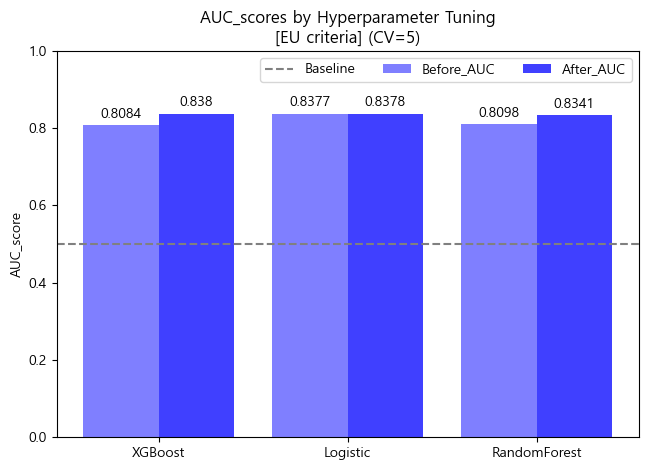

In [114]:
x = np.arange(3)
width = 0.4

fig, ax = plt.subplots()
rect1 = ax.bar(x-width/2, df_score_eu_tun.Before_AUC.round(4), width, label='Before_AUC',color='blue',alpha=0.5)
rect2 = ax.bar(x+width/2, df_score_eu_tun.After_AUC.round(4), width, label='After_AUC',color='blue',alpha=0.75)

ax.set_title('AUC_scores by Hyperparameter Tuning\n[EU criteria] (CV=5)')
ax.set_xticks(x, df_score_eu_tun.index)
ax.bar_label(rect1, padding=3)
ax.bar_label(rect2, padding=3)

fig.tight_layout()

plt.axhline(.5,color='gray',linestyle='--',label='Baseline')
plt.ylabel('AUC_score')
plt.ylim([0,1])
plt.legend(ncol=3)
plt.show()

## 5. Final Model test

### Final Model Evauation

#### US criteria

In [115]:
print(xgb_us_tun)
xgb_us_tun.fit(X_train,y_train_us)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=4,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=4,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [116]:
CV_pred_final_us = cross_val_predict(xgb_us_tun,X_train,y_train_us,cv=5,n_jobs=-1)
df_final_us = pd.DataFrame(data={'y_real_us':y_train_us,
                                 'y_pred_us':CV_pred_final_us})
table_final_us = pd.crosstab(df_final_us['y_real_us'],df_final_us['y_pred_us'])
display(table_final_us)

y_pred_us     0     1
y_real_us            
0          2940  1441
1          1048  3708

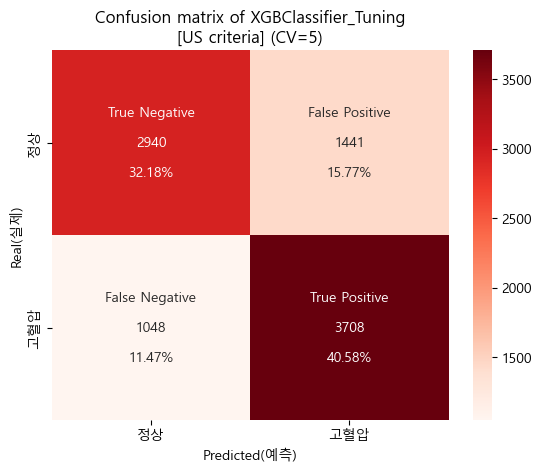

In [117]:
cfm_final_us = confusion_matrix(y_train_us,CV_pred_final_us)
group_names_final_us = ['True Negative','False Positive','False Negative','True Positive']
group_counts_final_us = ['{0:0.0f}'.format(value) for value in cfm_final_us.flatten()]
group_percentages_final_us = ['{0:.2%}'.format(value) for value in cfm_final_us.flatten()/np.sum(cfm_final_us)]
labels_final_us = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_final_us,group_counts_final_us,group_percentages_final_us)]
labels_final_us = np.asarray(labels_final_us).reshape(2,2)
tick_final_us = ['정상','고혈압']
sns.heatmap(cfm_final_us, annot=labels_final_us, fmt='',cmap='Reds',xticklabels=tick_final_us,yticklabels=tick_final_us)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of XGBClassifier_Tuning\n[US criteria] (CV=5)')
plt.show()

In [118]:
CV_score_accuracy_final_us = cross_val_score(xgb_us_tun,X_train,y_train_us,cv=5,n_jobs=-1,scoring='accuracy')
print('[US criteria]')
print("Baseline accuracy(US): {}".format(accuracy_score(y_train_us, baseline_us)))
print('XGBClassifier_Tuning accuracy(US): {}'.format(CV_score_accuracy_final_us.mean()))

[US criteria]
Baseline accuracy(US): 0.5205209587391922
XGBClassifier_Tuning accuracy(US): 0.7275927343195132


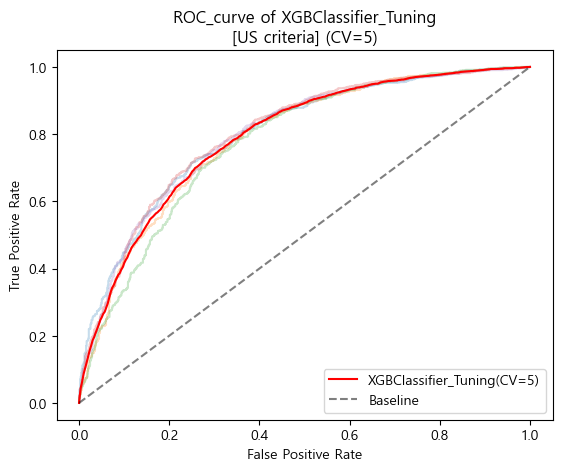

In [119]:
tprs_final_us = []
base_fpr_final_us = np.linspace(0,1,300)

for train_idx, val_idx in kf_5.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_us_cv, y_val_us_cv = y_train_us.iloc[train_idx], y_train_us.iloc[val_idx]
    
    xgb_us_tun.fit(X_train_cv,y_train_us_cv)
    
    y_val_us_prob = xgb_us_tun.predict_proba(X_val_cv)[:,1]
    FPR_final_us, TPR_final_us, _ = roc_curve(y_val_us_cv,y_val_us_prob)
    
    plt.plot(FPR_final_us,TPR_final_us,alpha=.25)
    tpr_us = np.interp(base_fpr_final_us,FPR_final_us,TPR_final_us)
    tpr_us[0] = 0.0
    tprs_final_us.append(tpr_us)
tprs_final_us = np.array(tprs_final_us)
mean_tprs_final_us = tprs_final_us.mean(axis=0)
plt.plot(base_fpr_final_us,mean_tprs_final_us,label='XGBClassifier_Tuning(CV=5)',color='red')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve of XGBClassifier_Tuning\n[US criteria] (CV=5)')
plt.legend(loc='lower right')
plt.show()

In [120]:
CV_score_auc_final_us = cross_val_score(xgb_us_tun,X_train,y_train_us,cv=5,n_jobs=-1,scoring='roc_auc')
print('[US criteria]')
print("Baseline AUC_score(US): {}".format(roc_auc_score(y_train_us, baseline_us)))
print('XGBClassifier_Tuning AUC_score(US) : {}'.format(CV_score_auc_final_us.mean()))

[US criteria]
Baseline AUC_score(US): 0.5
XGBClassifier_Tuning AUC_score(US) : 0.794148446162498


#### EU criteria

In [121]:
print(xgb_eu_tun)
xgb_eu_tun.fit(X_train,y_train_eu)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=8,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=8,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [122]:
CV_pred_final_eu = cross_val_predict(xgb_eu_tun,X_train,y_train_eu,cv=5,n_jobs=-1)
df_final_eu = pd.DataFrame(data={'y_real_eu':y_train_eu,
                                 'y_pred_eu':CV_pred_final_eu})
table_final_eu = pd.crosstab(df_final_eu['y_real_eu'],df_final_eu['y_pred_eu'])
display(table_final_eu)

y_pred_eu     0     1
y_real_eu            
0          5253   902
1          1182  1800

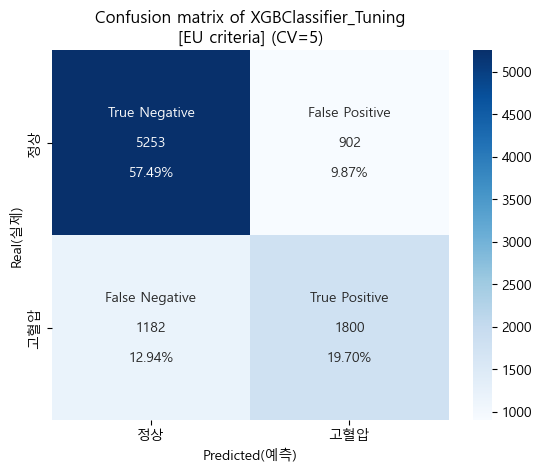

In [123]:
cfm_final_eu = confusion_matrix(y_train_eu,CV_pred_final_eu)
group_names_final_eu = ['True Negative','False Positive','False Negative','True Positive']
group_counts_final_eu = ['{0:0.0f}'.format(value) for value in cfm_final_eu.flatten()]
group_percentages_final_eu = ['{0:.2%}'.format(value) for value in cfm_final_eu.flatten()/np.sum(cfm_final_eu)]
labels_final_eu = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_final_eu,group_counts_final_eu,group_percentages_final_eu)]
labels_final_eu = np.asarray(labels_final_eu).reshape(2,2)
tick_final_eu = ['정상','고혈압']
sns.heatmap(cfm_final_eu, annot=labels_final_eu, fmt='',cmap='Blues',xticklabels=tick_final_eu,yticklabels=tick_final_eu)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of XGBClassifier_Tuning\n[EU criteria] (CV=5)')
plt.show()

In [124]:
CV_score_accuracy_final_eu = cross_val_score(xgb_eu_tun,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='accuracy')
print('[EU criteria]')
print("Baseline accuracy(EU): {}".format(accuracy_score(y_train_eu, baseline_eu)))
print('XGBClassifier_Tuning accuracy(EU): {}'.format(CV_score_accuracy_final_eu.mean()))

[EU criteria]
Baseline accuracy(EU): 0.6736346722118858
XGBClassifier_Tuning accuracy(EU): 0.7719166310353212


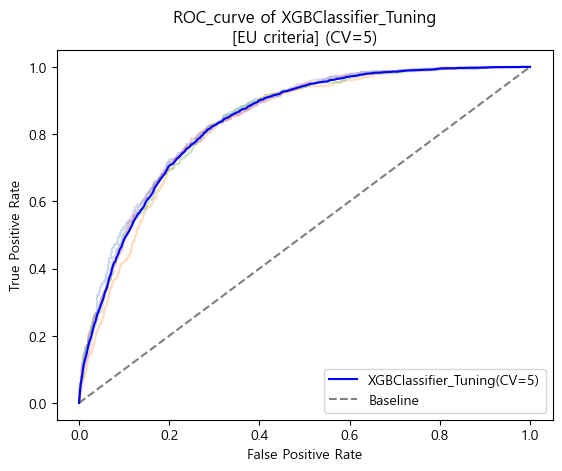

In [125]:
tprs_final_eu = []
base_fpr_final_eu = np.linspace(0,1,300)

for train_idx, val_idx in kf_5.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_eu_cv, y_val_eu_cv = y_train_eu.iloc[train_idx], y_train_eu.iloc[val_idx]
    
    xgb_eu_tun.fit(X_train_cv,y_train_eu_cv)
    
    y_val_eu_prob = xgb_eu_tun.predict_proba(X_val_cv)[:,1]
    FPR_final_eu, TPR_final_eu, _ = roc_curve(y_val_eu_cv,y_val_eu_prob)
    
    plt.plot(FPR_final_eu,TPR_final_eu,alpha=.25)
    tpr_eu = np.interp(base_fpr_final_eu,FPR_final_eu,TPR_final_eu)
    tpr_eu[0] = 0.0
    tprs_final_eu.append(tpr_eu)
tprs_final_eu = np.array(tprs_final_eu)
mean_tprs_final_eu = tprs_final_eu.mean(axis=0)
plt.plot(base_fpr_final_eu,mean_tprs_final_eu,label='XGBClassifier_Tuning(CV=5)',color='blue')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve of XGBClassifier_Tuning\n[EU criteria] (CV=5)')
plt.legend(loc='lower right')
plt.show()

In [126]:
CV_score_auc_final_eu = cross_val_score(xgb_eu_tun,X_train,y_train_eu,cv=5,n_jobs=-1,scoring='roc_auc')
print('[EU criteria]')
print("Baseline AUC_score(EU): {}".format(roc_auc_score(y_train_eu, baseline_eu)))
print('XGBClassifier_Tuning AUC_score(EU) : {}'.format(CV_score_auc_final_eu.mean()))

[EU criteria]
Baseline AUC_score(EU): 0.5
XGBClassifier_Tuning AUC_score(EU) : 0.8380314251605574


#### US & EU

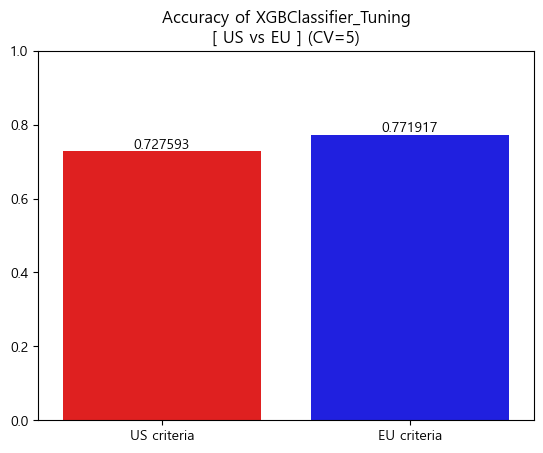

[Accuracy]

Baseline accuracy(US): 0.5205209587391922
Validation accuracy(US): 0.7275927343195132

Baseline accuracy(EU): 0.6736346722118858
Validation accuracy(EU): 0.7719166310353212



In [127]:
df_accuacy_final = pd.DataFrame({'US criteria':[CV_score_accuracy_final_us.mean()]
                                 ,'EU criteria':[CV_score_accuracy_final_eu.mean()]},
                                index=['Accuracy'])
ax = sns.barplot(data=df_accuacy_final,palette=['red','blue'])
ax.bar_label(ax.containers[0])
plt.title('Accuracy of XGBClassifier_Tuning\n[ US vs EU ] (CV=5)')
plt.ylim(0,1)
plt.show()

print('[Accuracy]\n')
print("Baseline accuracy(US): {}".format(accuracy_score(y_train_us, baseline_us)))
print('Validation accuracy(US): {}\n'.format(CV_score_accuracy_final_us.mean()))
print("Baseline accuracy(EU): {}".format(accuracy_score(y_train_eu, baseline_eu)))
print('Validation accuracy(EU): {}\n'.format(CV_score_accuracy_final_eu.mean()))

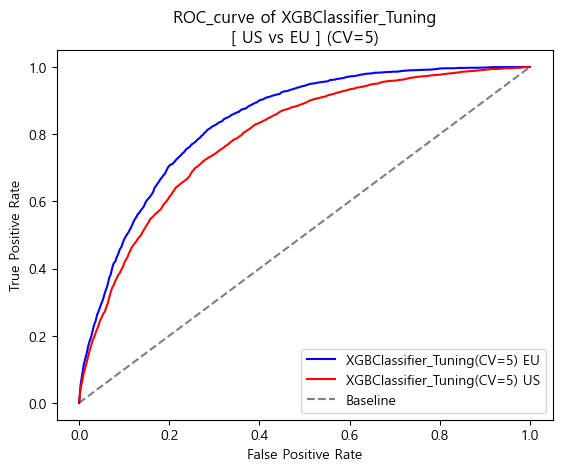

[AUC_score]

Baseline AUC_score : 0.5
XGBClassifier_Tuning AUC_score(US) : 0.794148446162498
XGBClassifier_Tuning AUC_score(EU) : 0.8380314251605574


In [128]:
plt.plot(base_fpr_final_eu,mean_tprs_final_eu,label='XGBClassifier_Tuning(CV=5) EU',color='blue')
plt.plot(base_fpr_final_us,mean_tprs_final_us,label='XGBClassifier_Tuning(CV=5) US',color='red')
plt.plot([0,1],[0,1],label='Baseline',color='black',linestyle='--',alpha=0.5)
plt.title('ROC_curve of XGBClassifier_Tuning\n[ US vs EU ] (CV=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print('[AUC_score]\n')
print('Baseline AUC_score : 0.5')
print('XGBClassifier_Tuning AUC_score(US) : {}'.format(CV_score_auc_final_us.mean()))
print('XGBClassifier_Tuning AUC_score(EU) : {}'.format(CV_score_auc_final_eu.mean()))

### Final Model Test

#### US criteria

In [129]:
y_pred_test_us = xgb_us_tun.predict(X_test)
df_test_us = pd.DataFrame(data={'y_real_us':y_test_us,
                                'y_pred_us':y_pred_test_us})
table_test_us = pd.crosstab(df_test_us['y_real_us'],df_test_us['y_pred_us'])
display(table_test_us)

y_pred_us    0    1
y_real_us          
0          711  392
1          306  876

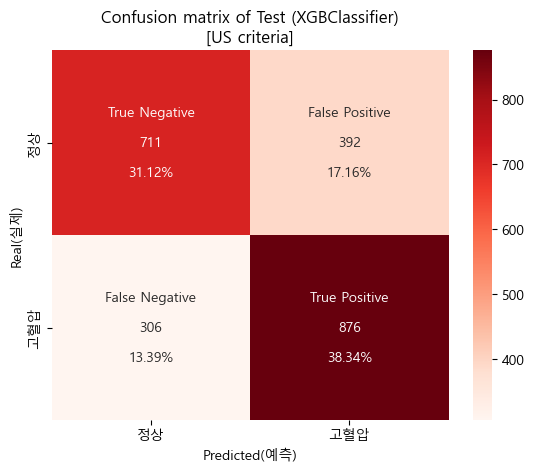

In [130]:
cfm_test_us = confusion_matrix(y_test_us,y_pred_test_us)
group_names_test_us = ['True Negative','False Positive','False Negative','True Positive']
group_counts_test_us = ['{0:0.0f}'.format(value) for value in cfm_test_us.flatten()]
group_percentages_test_us = ['{0:.2%}'.format(value) for value in cfm_test_us.flatten()/np.sum(cfm_test_us)]
labels_test_us = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_test_us,group_counts_test_us,group_percentages_test_us)]
labels_test_us = np.asarray(labels_test_us).reshape(2,2)
tick_test_us = ['정상','고혈압']
sns.heatmap(cfm_test_us, annot=labels_test_us, fmt='',cmap='Reds',xticklabels=tick_test_us,yticklabels=tick_test_us)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of Test (XGBClassifier)\n[US criteria]')
plt.show()

In [131]:
score_accuracy_test_us = accuracy_score(y_test_us,y_pred_test_us)
print('[US criteria]')
print("Baseline accuracy(US): {}".format(accuracy_score(y_train_us, baseline_us)))
print('Validation accuracy(US, CV=5): {}'.format(CV_score_accuracy_final_us.mean()))
print('Test accuracy(US): {}'.format(score_accuracy_test_us))

[US criteria]
Baseline accuracy(US): 0.5205209587391922
Validation accuracy(US, CV=5): 0.7275927343195132
Test accuracy(US): 0.6945295404814005


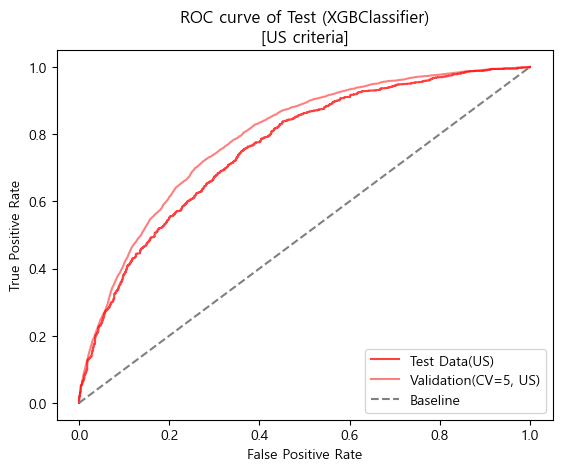

In [132]:
y_test_prob_us = xgb_us_tun.predict_proba(X_test)[:,1]

FPR_test_us, TPR_test_us, _ = roc_curve(y_test_us,y_test_prob_us)

plt.plot(FPR_test_us,TPR_test_us,label='Test Data(US)',color='red',alpha=0.75)
plt.plot(base_fpr_final_us,mean_tprs_final_us,label='Validation(CV=5, US)',color='red',alpha=0.5)
plt.plot([0,1],[0,1], linestyle='--', label='Baseline', color = 'gray')
plt.title('ROC curve of Test (XGBClassifier)\n[US criteria]')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [133]:
score_auc_test_us = roc_auc_score(y_test_us,y_test_prob_us)
print('[US criteria]')
print("Baseline AUC_score(US): {}".format(roc_auc_score(y_train_us, baseline_us)))
print('Validation AUC_score(US, CV=5): {}'.format(CV_score_auc_final_us.mean()))
print('Test AUC_score(US): {}'.format(score_auc_test_us))

[US criteria]
Baseline AUC_score(US): 0.5
Validation AUC_score(US, CV=5): 0.794148446162498
Test AUC_score(US): 0.7608080868512732


#### EU criteria

In [134]:
y_pred_test_eu = xgb_eu_tun.predict(X_test)
df_test_eu = pd.DataFrame(data={'y_real_eu':y_test_eu,
                                'y_pred_eu':y_pred_test_eu})
table_test_eu = pd.crosstab(df_test_eu['y_real_eu'],df_test_eu['y_pred_eu'])
display(table_test_eu)

y_pred_eu     0    1
y_real_eu           
0          1342  226
1           304  413

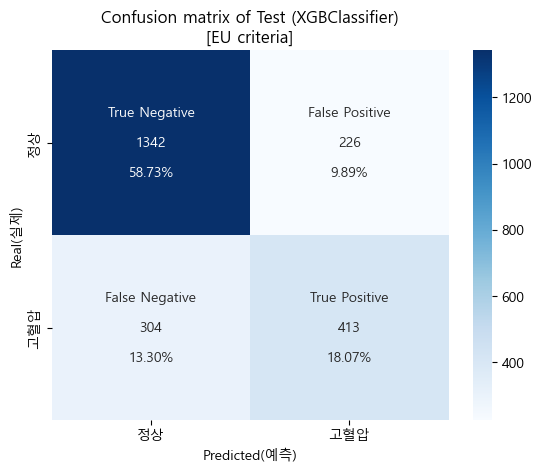

In [135]:
cfm_test_eu = confusion_matrix(y_test_eu,y_pred_test_eu)
group_names_test_eu = ['True Negative','False Positive','False Negative','True Positive']
group_counts_test_eu = ['{0:0.0f}'.format(value) for value in cfm_test_eu.flatten()]
group_percentages_test_eu = ['{0:.2%}'.format(value) for value in cfm_test_eu.flatten()/np.sum(cfm_test_eu)]
labels_test_eu = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_test_eu,group_counts_test_eu,group_percentages_test_eu)]
labels_test_eu = np.asarray(labels_test_eu).reshape(2,2)
tick_test_eu = ['정상','고혈압']
sns.heatmap(cfm_test_eu, annot=labels_test_eu, fmt='',cmap='Blues',xticklabels=tick_test_eu,yticklabels=tick_test_eu)
plt.xlabel('Predicted(예측)')
plt.ylabel('Real(실제)')
plt.title('Confusion matrix of Test (XGBClassifier)\n[EU criteria]')
plt.show()

In [136]:
score_accuracy_test_eu = accuracy_score(y_test_eu,y_pred_test_eu)
print('[EU criteria]')
print("Baseline accuracy(EU): {}".format(accuracy_score(y_train_eu, baseline_eu)))
print('Validation accuracy(EU, CV=5): {}'.format(CV_score_accuracy_final_eu.mean()))
print('Test accuracy(EU): {}'.format(score_accuracy_test_eu))

[EU criteria]
Baseline accuracy(EU): 0.6736346722118858
Validation accuracy(EU, CV=5): 0.7719166310353212
Test accuracy(EU): 0.7680525164113785


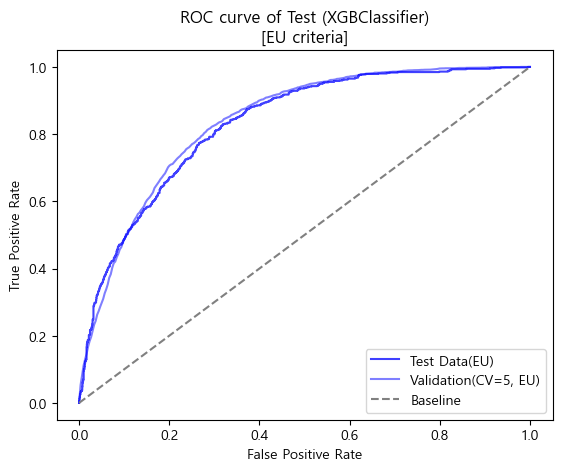

In [137]:
y_test_prob_eu = xgb_eu_tun.predict_proba(X_test)[:,1]

FPR_test_eu, TPR_test_eu, _ = roc_curve(y_test_eu,y_test_prob_eu)

plt.plot(FPR_test_eu,TPR_test_eu,label='Test Data(EU)',color='blue',alpha=0.75)
plt.plot(base_fpr_final_eu,mean_tprs_final_eu,label='Validation(CV=5, EU)',color='blue',alpha=0.5)
plt.plot([0,1],[0,1], linestyle='--', label='Baseline', color = 'gray')
plt.title('ROC curve of Test (XGBClassifier)\n[EU criteria]')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [138]:
score_auc_test_eu = roc_auc_score(y_test_eu,y_test_prob_eu)
print('[EU criteria]')
print("Baseline AUC_score(EU): {}".format(roc_auc_score(y_train_eu, baseline_eu)))
print('Validation AUC_score(EU): {}'.format(CV_score_auc_final_eu.mean()))
print('Test AUC_score(EU): {}'.format(score_auc_test_eu))

[EU criteria]
Baseline AUC_score(EU): 0.5
Validation AUC_score(EU): 0.8380314251605574
Test AUC_score(EU): 0.8300106915150998


#### US & EU

In [139]:
print('[Accuracy]')
print('Validation accuracy(US): {}'.format(CV_score_accuracy_final_us.mean()))
print('Test accuracy(US): {}'.format(score_accuracy_test_us))
print('Validation accuracy(EU): {}'.format(CV_score_accuracy_final_eu.mean()))
print('Test accuracy(EU): {}'.format(score_accuracy_test_eu))

[Accuracy]
Validation accuracy(US): 0.7275927343195132
Test accuracy(US): 0.6945295404814005
Validation accuracy(EU): 0.7719166310353212
Test accuracy(EU): 0.7680525164113785


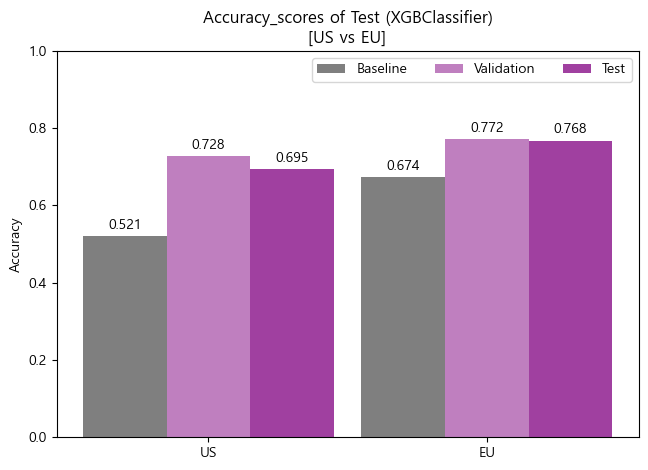

In [140]:
df_accuracy_test = pd.DataFrame({'Baseline':[accuracy_score(y_train_us, baseline_us),
                                             accuracy_score(y_train_eu, baseline_eu)],
                                 'Validation':[CV_score_accuracy_final_us.mean(),
                                               CV_score_accuracy_final_eu.mean()],
                                 'Test':[score_accuracy_test_us,
                                         score_accuracy_test_eu]},
                                index=['US','EU'])

x = np.arange(2)
width = 0.3

fig, ax = plt.subplots()
rect1 = ax.bar(x-width, df_accuracy_test.Baseline.round(3), width, label='Baseline',color='black',alpha=0.5)
rect2 = ax.bar(x, df_accuracy_test.Validation.round(3), width, label='Validation',color='purple',alpha=0.5)
rect3 = ax.bar(x+width, df_accuracy_test.Test.round(3), width, label='Test',color='purple',alpha=0.75)

ax.set_title('Accuracy_scores of Test (XGBClassifier)\n[US vs EU]')
ax.set_xticks(x, df_accuracy_test.index)
ax.bar_label(rect1, padding=3)
ax.bar_label(rect2, padding=3)
ax.bar_label(rect3, padding=3)

fig.tight_layout()

plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(ncol=3)
plt.show()

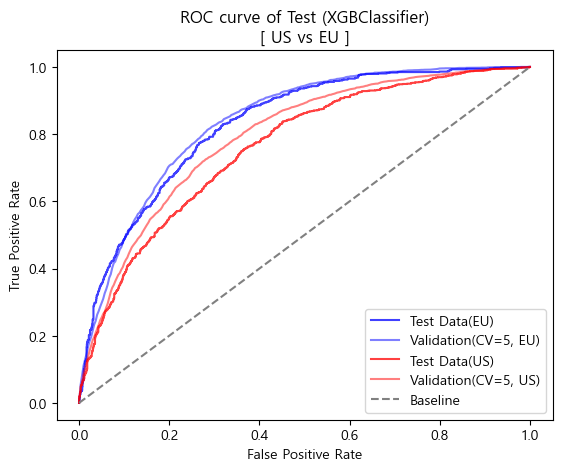

[AUC_score]
Validation AUC_score(US): 0.794148446162498
Test AUC_score(US): 0.7608080868512732
Validation AUC_score(EU): 0.8380314251605574
Test AUC_score(EU): 0.8300106915150998


In [141]:
plt.plot(FPR_test_eu,TPR_test_eu,label='Test Data(EU)',color='blue',alpha=0.75)
plt.plot(base_fpr_final_eu,mean_tprs_final_eu,label='Validation(CV=5, EU)',color='blue',alpha=0.5)
plt.plot(FPR_test_us,TPR_test_us,label='Test Data(US)',color='red',alpha=0.75)
plt.plot(base_fpr_final_us,mean_tprs_final_us,label='Validation(CV=5, US)',color='red',alpha=0.5)
plt.plot([0,1],[0,1], linestyle='--', label='Baseline', color = 'gray')
plt.title('ROC curve of Test (XGBClassifier)\n[ US vs EU ]')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print('[AUC_score]')
print('Validation AUC_score(US): {}'.format(CV_score_auc_final_us.mean()))
print('Test AUC_score(US): {}'.format(score_auc_test_us))
print('Validation AUC_score(EU): {}'.format(CV_score_auc_final_eu.mean()))
print('Test AUC_score(EU): {}'.format(score_auc_test_eu))